# World Data League 2022

## 🎯 Challenge
Predicting a safety score for Women in Costa Rica

## 👥 Authors
* Catarina Bento
* Cátia Correia
* José Luís Mourão
* Lúcia Moreira

## 💻 Development

### Libraries needed

Installation of python libraries that were missing and import of all the libraries needed.

In [65]:
# !sudo pip install meteostat
# !sudo pip install lightgbm
# !sudo pip install tabulate
# !sudo pip install unidecode

In [1]:
import pandas as pd
import numpy as np
import datetime
import psycopg2
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import seaborn as sns
import os
import requests
import io
import math
import unidecode
from datetime import datetime
from meteostat import Point, Hourly
import calendar
import json
import lightgbm as lgb
from tabulate import tabulate
import sklearn
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

### Data Pre-processing

We hosted the csv files in our virtual machine and will import them for a first look at the data.

We decided early on to **focus on the canton of San Jose**. While we would like to help all women in Costa Rica to feel safe, we believe that we can analyze and study one canton and reach conclusions and present our findings without loss of quality in this regard.

Then, as part of **future work**, we could take the same approach to other cantons, and depending on the distinct features of each canton (because different zones may have different problems/causes), either apply the same method or improve it.

For the first dataset, **"district_data"**, besides the usual cleaning of data and checking for missing values (**no missing values**), we normalized the columns with the rates of certain factors and plotted them by district, to see how each San Jose district compares.

We can divide this dataset in 3 parts:
- **crime features** (1)
- **social-economic features** (2)
- **demographic features** (3)

In [2]:
# reading data
district_data = pd.read_csv('district_data.csv', names=['index', 'unique_code', 'zone', 'assaults_rate_2016', 'homicides_rate_2016', 'theft_rate_2016', \
                                                       'robbery_rate_2016', 'vehicle_theft_rate_2016', 'rape_rate_2016', 'economic_ids_2017', \
                                                       'citizen_participation_ids_2017', 'health_ids_2017', 'education_ids_2017', 'security_ids_2017', \
                                                       'social_development_ids_2017', 'tot_pop_2011', 'pop_dens_2011', 'urban_pop_perc_2011', \
                                                       'm2f_ratio_2011', 'active_pop_2011', 'pop_elder_2011', 'pop_foreign_2011', 'pop_married_2011', \
                                                       'pop_disabled_2011', 'pop_wo_ss_2011'], \
                            skiprows=1)
# dropping index column
district_data.drop(columns=['index'])

# splitting region data and cleaning up subsequent columns
district_data[['province', 'canton', 'district']] = district_data.zone.str.split(',',n=3,expand=True)
district_data['province'] = district_data['province'].str.replace('[^\w\s]', '')
district_data['canton'] = district_data['canton'].str.replace('[^\w\s]', '')
district_data['district'] = district_data['district'].str.replace('[^\w\s]', '')
district_data['district'] = district_data['district'].str.strip()

# rename columns
district_data = pd.DataFrame(district_data, columns=['province', 'canton', 'district', \
                                                     'assaults_rate_2016', 'homicides_rate_2016', 'theft_rate_2016', \
                                                     'robbery_rate_2016', 'vehicle_theft_rate_2016', 'rape_rate_2016', 'economic_ids_2017', \
                                                     'citizen_participation_ids_2017', 'health_ids_2017', 'education_ids_2017', 'security_ids_2017', \
                                                     'social_development_ids_2017', 'tot_pop_2011', 'pop_dens_2011', 'urban_pop_perc_2011', \
                                                     'm2f_ratio_2011', 'active_pop_2011', 'pop_elder_2011', 'pop_foreign_2011', 'pop_married_2011', \
                                                     'pop_disabled_2011', 'pop_wo_ss_2011'])

# filter for the canton of San Jose
district_data = district_data[(district_data['province'] == 'SAN JOSE') & (district_data['canton'] == ' SAN JOSE')]

# remove urban population percentage column --> San Jose is a urban zone so the value is 100% for all districts
district_data.drop(columns=['urban_pop_perc_2011'], inplace=True)

# column not defined as float
district_data['pop_elder_2011'] = district_data['pop_elder_2011'].astype(float)

# check for missing values
print('Missing values: ', district_data.isna().sum().sum())

Missing values:  0


Looking at the plots for (1), we see that there are a lot of discrepancies across districts and that the districts of Carmen, Catedral and Merced are the 3 worst "performers" in these fields, while Uruca, Hatillo and Pavas show the best values.

When analyzing the plots for (2), we could assume that we'd find a kind of correlation between the previous plots: a more educated and socially and economically developed district should present lower crime rates. But what we found out is that was not the case at all. San Francisco de Dos Rios, Mata Redonda and Zapote lead the way in the IDS 2017 components, while Hospital, Merced and Uruca are at the bottom.

Regarding the demographic data (3), the most interesting conclusion that we found out is that the districts with higher male to female ratio are the same ones that have the worst IDS values: Hospital, Merced and Uruca.

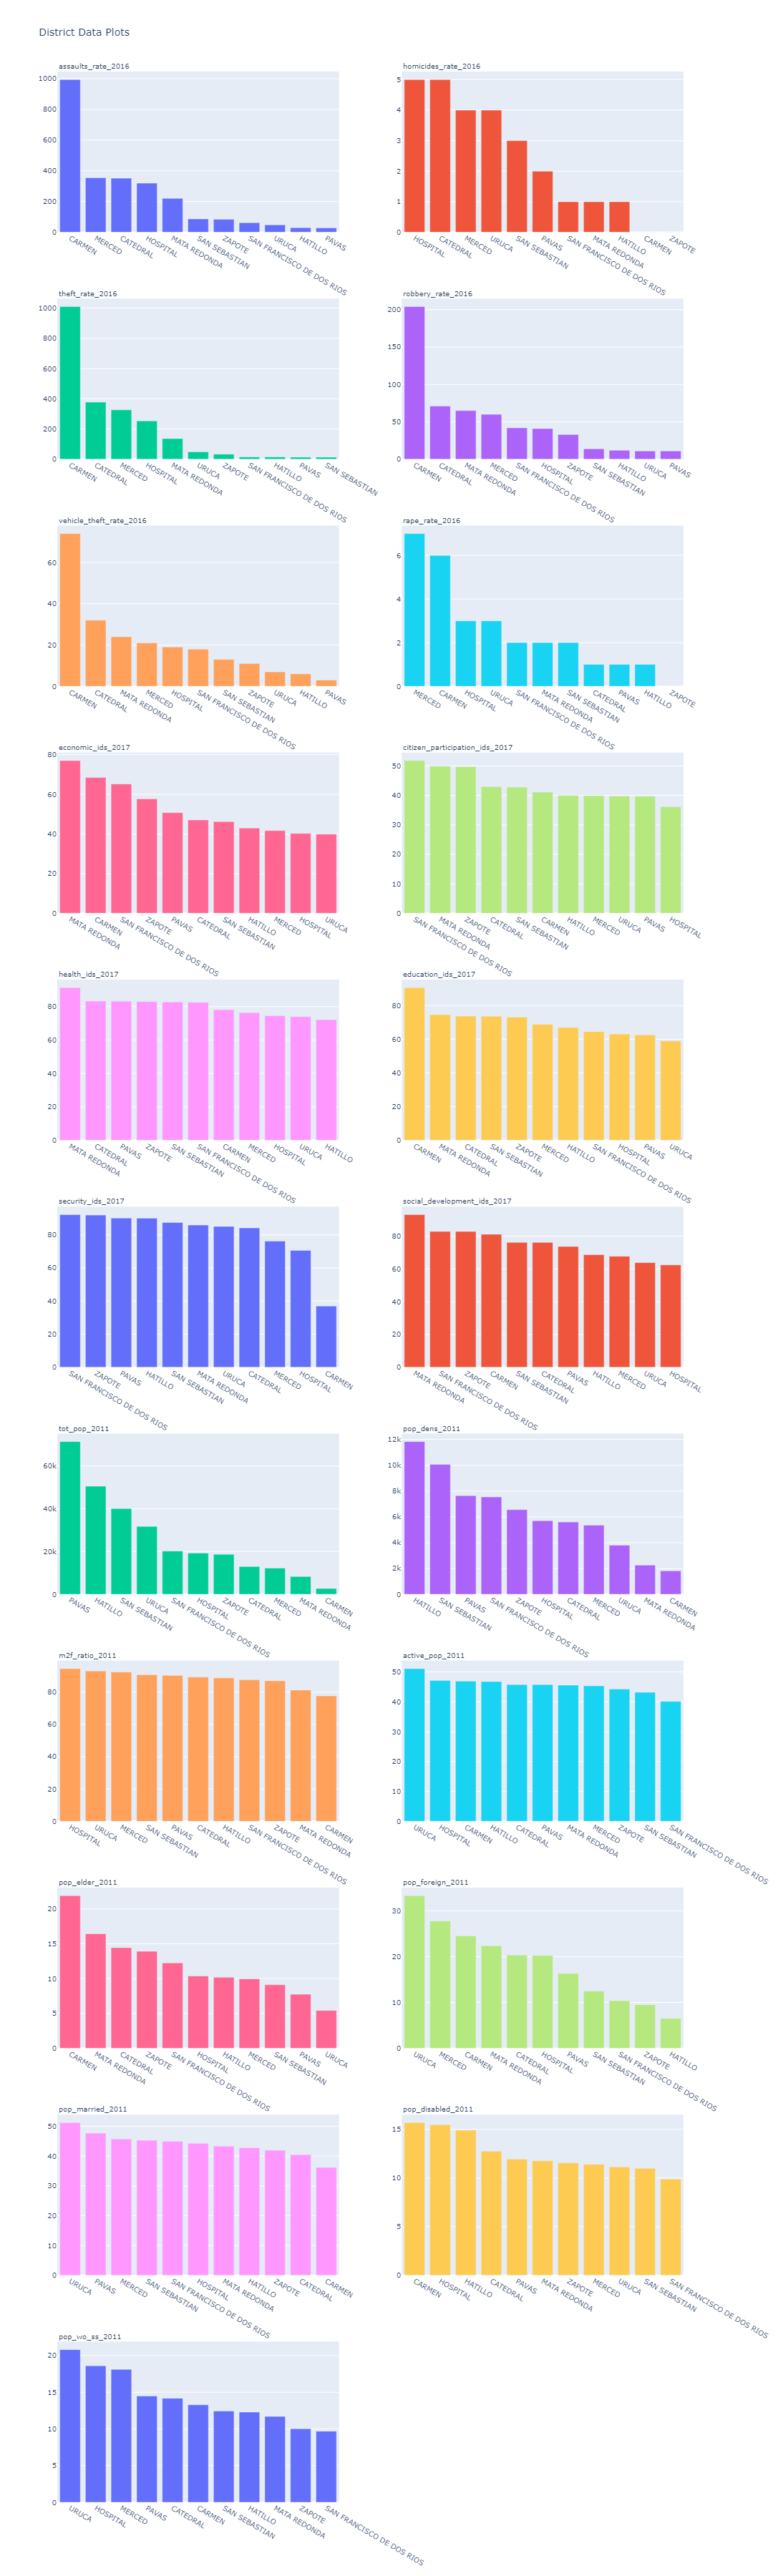

In [3]:
columns_to_plot = ['assaults_rate_2016', 'homicides_rate_2016', 'theft_rate_2016', 'robbery_rate_2016', 'vehicle_theft_rate_2016', 'rape_rate_2016', 'economic_ids_2017', 
        'citizen_participation_ids_2017', 'health_ids_2017', 'education_ids_2017', 'security_ids_2017', 'social_development_ids_2017', 'tot_pop_2011', 'pop_dens_2011', 'm2f_ratio_2011',
        'active_pop_2011', 'pop_elder_2011', 'pop_foreign_2011', 'pop_married_2011', 'pop_disabled_2011', 'pop_wo_ss_2011']
fig = make_subplots(rows=11, cols=2)

i=1
j=1

for col in columns_to_plot:
    a = district_data[['district', col]]
    a.sort_values(by=col, ascending=False, inplace=True)

    fig.add_trace(
        go.Bar(x=a['district'], y=a[col]),
        row=i, col=j
    )
    fig.add_annotation(xref="x domain",yref="y domain",x=0, y=1.07, showarrow=False,
                   text=f'{col}', row=i, col=j)

    if j % 2 == 0:
        j = 1
        i += 1
    else:
        j += 1

fig.update_layout(height=3600, width=1200, title_text="District Data Plots",showlegend=False, font=dict(size=10))
fig.show()

For the second dataset, **"costa_rica_street_harassement"**, when filtering for the canton of San Jose, we were faced with very few data points.

At first sight, this is a very important dataset to use, but after checking with the organizers, we were told that this contains **only data from 2021**.
Coupled with the fact that **sexual harassment is a very seriously under-reported crime**, we only had data for 3 districts: Catedral, Hatillo and Pavas.

The district of **Catedral** has a total of 25 reported sexual harassment crimes.
We already knew that Catedral has higher crime rates, so it's no surprise that sexual harassment crimes also present themselves in greater numbers.

The two other districts, **Hatillo and Pavas**, have 9 each.

In [4]:
# read data
costa_rica_street_harassement = pd.read_csv('costa_rica_street_harassement_english.csv')

# filter for the canton of San Jose
costa_rica_street_harassement = costa_rica_street_harassement[(costa_rica_street_harassement['province'] == 'San Jose') \
                                                              & (costa_rica_street_harassement['canton'] == 'San Jose')]

# group by
costa_rica_street_harassement = costa_rica_street_harassement[['province','canton','district','sexual_harassement', \
                                                               'exhibitionism','pursuit_or_cornering','production_of_audiovisual_material', \
                                                               'sexual_harassement_law']]. \
                                groupby(['province','canton','district']). \
                                agg({'sexual_harassement':'sum','exhibitionism':'sum','pursuit_or_cornering':'sum', \
                                     'production_of_audiovisual_material':'sum','sexual_harassement_law':'sum'}).reset_index()

# group the two sexual harasmment columns as one
costa_rica_street_harassement['sexual_harassement'] = costa_rica_street_harassement['sexual_harassement'] + costa_rica_street_harassement['sexual_harassement_law']
costa_rica_street_harassement.drop(columns=['sexual_harassement_law'], inplace=True)

# switch to uppercase, to align with other datasets
costa_rica_street_harassement['province'] = costa_rica_street_harassement['province'].apply(lambda x: x.upper())
costa_rica_street_harassement['canton'] = costa_rica_street_harassement['canton'].apply(lambda x: x.upper())
costa_rica_street_harassement['district'] = costa_rica_street_harassement['district'].apply(lambda x: x.upper())

# rename columns
costa_rica_street_harassement.columns = ['province', 'canton', 'district', 'sexual_harassement_2021', 'exhibitionism_2021', 'pursuit_or_cornering_2021', 'production_of_audiovisual_material_2021']
costa_rica_street_harassement

province    canton  district  sexual_harassement_2021  exhibitionism_2021  \
0  SAN JOSE  SAN JOSE  CATEDRAL                        5                   7   
1  SAN JOSE  SAN JOSE   HATILLO                        7                   1   
2  SAN JOSE  SAN JOSE     PAVAS                        5                   4   

   pursuit_or_cornering_2021  production_of_audiovisual_material_2021  
0                          8                                        5  
1                          0                                        1  
2                          0                                        0

For the third dataset, **"costa_rica_crimes_english"**, we again restricted our data to the canton of San Jose. In addition to this, since this dataset is a repository of all crimes reported, in an individual basis, we also limited the analysis to crimes committed against women.

We checked for missing values and verified there were none in the dataset.

We then transformed columns like age and time of day to categorical features, and created a new column for trimester.

In [5]:
# read data
costa_rica_crimes = pd.read_csv('costa_rica_crimes_english.csv')

# drop index column
costa_rica_crimes.drop(columns='Unnamed: 0', inplace=True)

# filter for the canton of San Jose and for crimes committed against women
costa_rica_crimes = costa_rica_crimes[(costa_rica_crimes['Province'] == 'SAN JOSE') & (costa_rica_crimes['Canton'] == 'SAN JOSE') & \
                                      ~(costa_rica_crimes['District'].isin(['DESCONOCIDO'])) & (costa_rica_crimes['Gender'] == 'female')]

# check for missing values
print('Missing values: ', district_data.isna().sum().sum())

# split date column
costa_rica_crimes[['day', 'month', 'year']] = costa_rica_crimes.Date.str.split('.',n=3,expand=True)
costa_rica_crimes['year'] = '20'+costa_rica_crimes['year']

# transform time of day column into categorical
morning = ['06:00:00 - 08:59:59', '09:00:00 - 11:59:59']
afternoon = ['12:00:00 - 14:59:59', '15:00:00 - 17:59:59']
costa_rica_crimes['period_of_day'] = costa_rica_crimes.apply(lambda row: 'Morning' if row['Time'] in morning else ('Afternoon' if row['Time'] in afternoon else 'Night'), axis=1)

# transform age column into categorical
costa_rica_crimes['age'] = costa_rica_crimes.apply(lambda row: 'Minor' if row['Age'] == '< 18 y/o' else ('Elder' if row['Age'] == '> 60 y/o' else 'Adult'), axis=1)

t1 = ['01','02','03']
t2 = ['04','05','06']
t3 = ['07','08','09']

# create trimester column
costa_rica_crimes['trimester'] = costa_rica_crimes.apply(lambda row: 1 if row['month'] in t1 else (2 if row['month'] in t2 else (3 if row['month'] in t3 else 4)), axis=1)

# create new column filled with '1', for counting purposes
costa_rica_crimes['contador'] = 1

Missing values:  0


In the 12 years of reported crimes present in the dataset, **36.807 crimes against women were commited**.

Based on the literature consulted, we know that **crimes against women are less reported than crimes against men**, so this figure does not reflect the reality of the problem. Another important point is that almost all of the crimes under the umbrella of sexual harrasment/assault are committed against women and the nature of the crime is of special relevance. These crimes tend to be even less reported than other types of crimes, due to the violent toll it inflicts upon women, the historical difficulty of believing the victims, the fact that most of the times evidence is harder to present, among others. So, there is an inherent bias on the data itself, which may hinder a more accurate depiction of the reality.

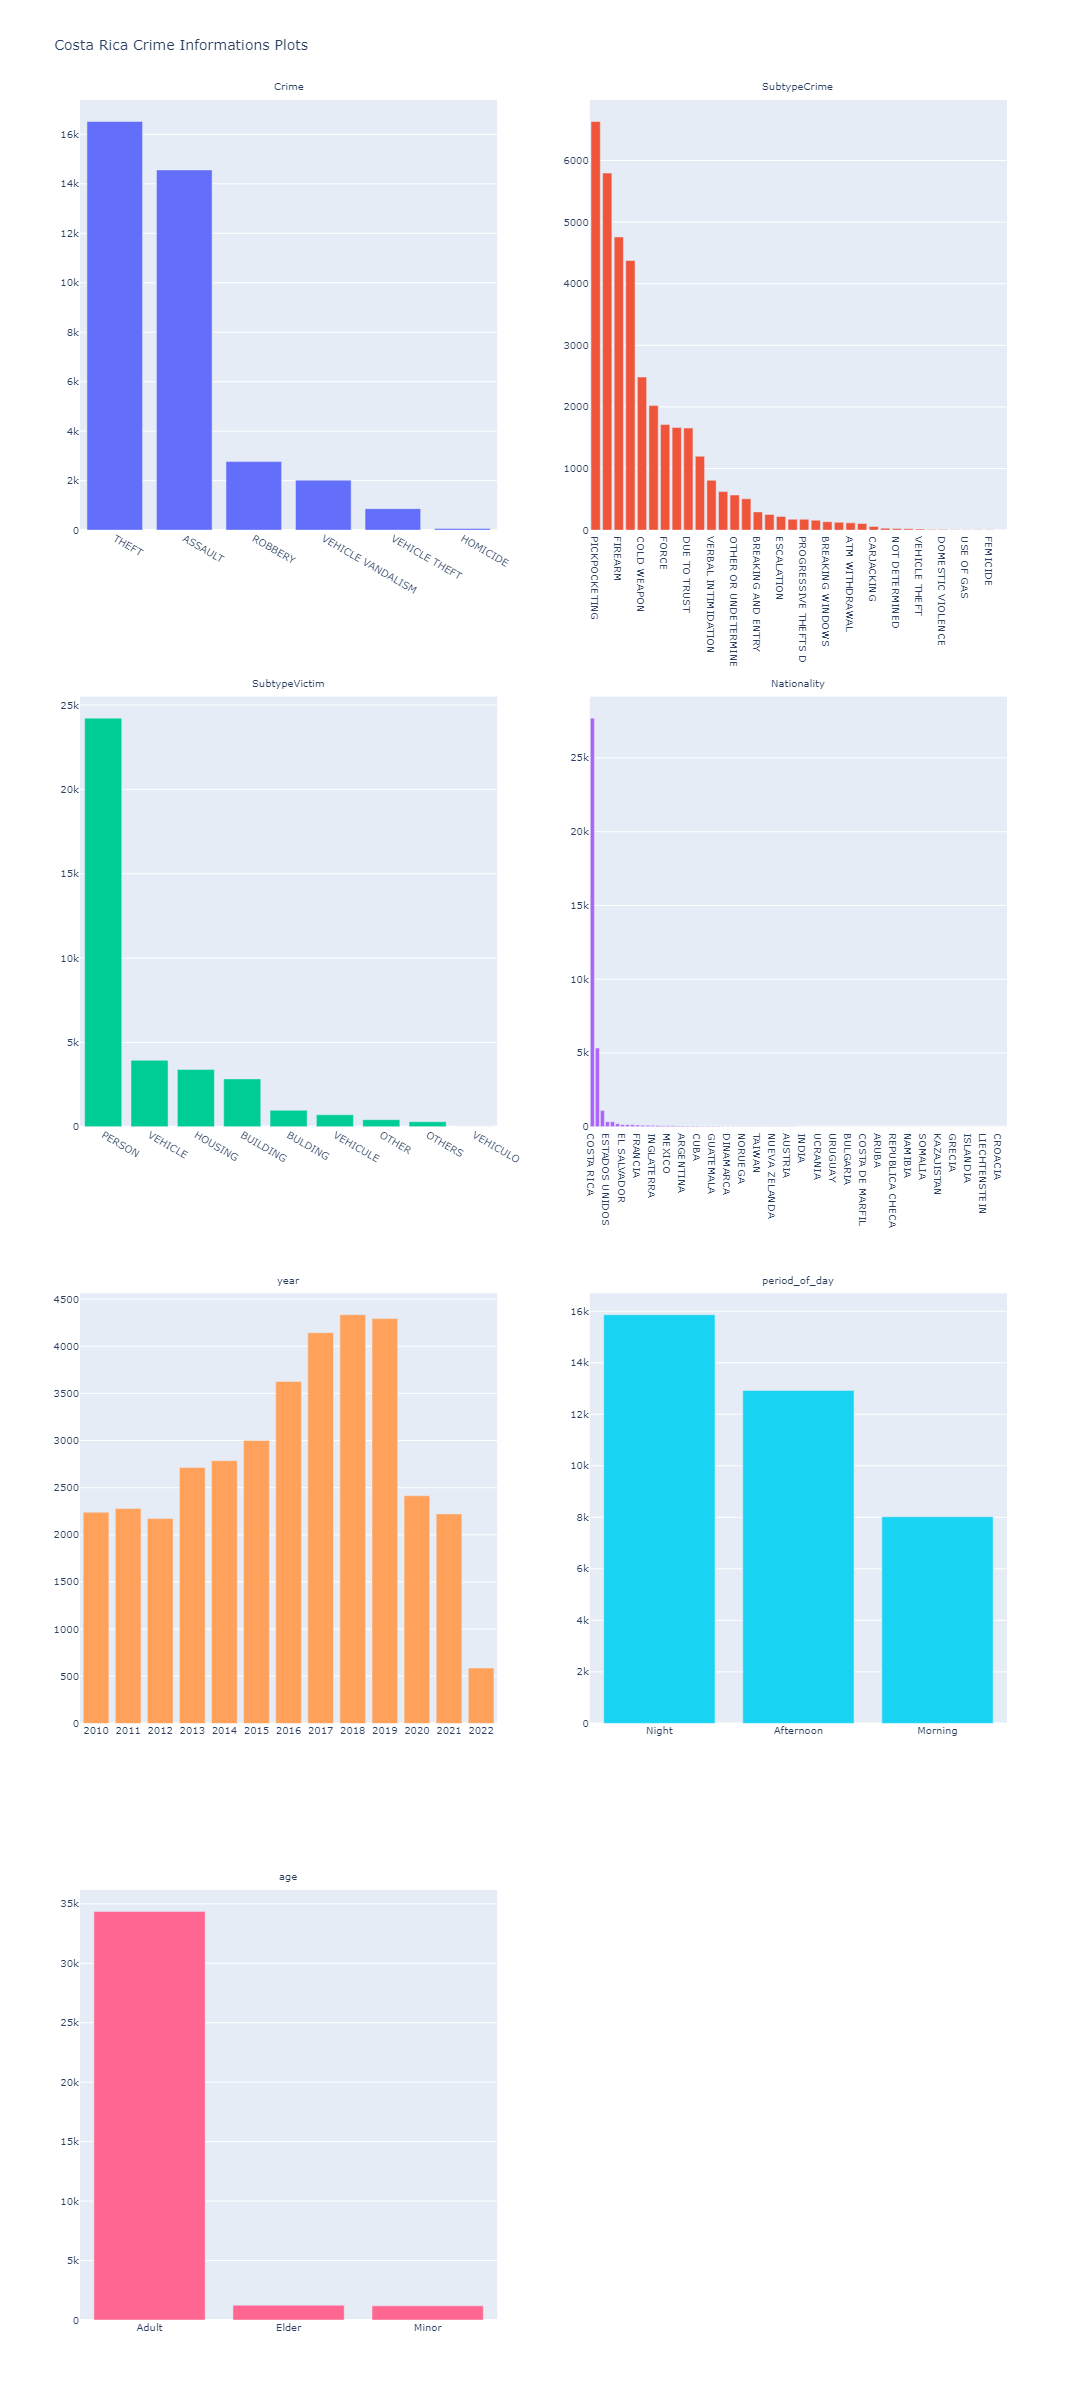

In [6]:
columns_to_plot = ['Crime', 'SubtypeCrime', 'SubtypeVictim', 'Nationality', 'year', 'period_of_day', 'age']

fig = make_subplots(rows=4, cols=2)

i=1
j=1

for col in columns_to_plot:
    if col == 'year':
        a = pd.DataFrame(costa_rica_crimes[col].value_counts()).reset_index().sort_values(by='index')
    elif col == 'SubtypeCrime':
        a = pd.DataFrame(costa_rica_crimes['SubtypeCrime'].value_counts()).reset_index()
        a['index'] = a['index'].apply(lambda x: str(x))
        a['index'] = a['index'].apply(lambda x: x[:20])
    elif col == 'SubtypeVictim':
        a = pd.DataFrame(costa_rica_crimes['SubtypeVictim']).reset_index()
        a['SubtypeVictim'] = a['SubtypeVictim'].apply(lambda x: str(x))
        a[['del', 'Victim']] = a.SubtypeVictim.str.split('[',n=2,expand=True)
        a['Victim'] = a['Victim'].apply(lambda x: x[:-1])
        a = pd.DataFrame(a['Victim'].value_counts()).reset_index()
        a.columns = ['index', 'SubtypeVictim']
    else:
        a = pd.DataFrame(costa_rica_crimes[col].value_counts(ascending=False)).reset_index()

    fig.add_trace(
        go.Bar(x=a['index'], y=a[col]),
        row=i, col=j
    )
    fig.add_annotation(xref="x domain",yref="y domain",x=0.5, y=1.05, showarrow=False,
                   text=f'{col}', row=i, col=j)

    if j % 2 == 0:
        j = 1
        i += 1
    else:
        j += 1

fig.update_layout(height=2400, width=1200, title_text="Costa Rica Crime Informations Plots",showlegend=False, font=dict(size=10))
fig.show()

Visualizing the data, we can account for the following:

- the **most frequent crimes** against women are **theft and assault**, while homicide is very rare (not ignoring the more brutal aspect of this crime in relation to theft)
- the **top 5 subtypes of crimes** against women are **pickpocketing, 'due to neglect', firearm, outburst and cold weapon**, which coincides with the previous conclusion
- the grand majority of crimes are perpetrated against people (66%), followed by houses/builidings (20%) and then vehicles belonging to women (13%)
- most crimes were committed against Costa Rican women and then Nicaraguan women, which makes sense since it's a neighbouring country
- there has been an **increase in crimes since 2012**, with a **decrease in 2020**:
    - since we are dealing with reported crimes, it doesn't mean that crimes have increased but rather that women are reporting them more. Without more information, we can't conclude anything about the real number of crimes; nonetheless, we believe there has been a change in costumes, leading to more women feeling comfortable reporting crimes
    - the sharp decrease in 2020 can be explained by the Covid-19 pandemic, since it led to people staying inside; our analysis is going to be focused on public spaces but we acknowledge that crimes committed inside the household may have increased (domestic violence)
- as the **day progresses from morning to night**, the **number of crimes also increases**: the fact that there's less light gives more protection to the assailants
- **almost all of the crimes** were commited against **women with ages between 18 and 60**, with the number of crimes against elder women basically the same as the number of crimes against women with less than 18 years

We will know consider the variables **Crime**, **SubtypeCrime** (considering only the top 5 subtypes of crimes committed against women), **period of day**, **age** as features for further analysis.

We are going to group them together by district and year (and also by district, year and trimester).

Then, we will link the 3 datasets, combining the social-economical and demographical data with the crime data.

In [7]:
# Dataset by year
# Crime feature grouping
cr_crime_year = costa_rica_crimes[['Crime', 'year', 'contador', 'District']]
cr_crime_year = cr_crime_year.pivot_table(values = 'contador', index = ['year', 'District'], columns = 'Crime', aggfunc = ['count'], margins = True, fill_value = 0)
cr_crime_year = cr_crime_year.droplevel(0, axis=1)
cr_crime_year = cr_crime_year.reset_index().rename_axis(None, axis=1)
cr_crime_year = cr_crime_year.drop(columns='All')
cr_crime_year = cr_crime_year.drop(cr_crime_year.tail(1).index)

# SubCrime feature grouping
cr_subcrime_year = costa_rica_crimes[['SubtypeCrime', 'year', 'contador', 'District']]
cr_subcrime_year = cr_subcrime_year[(costa_rica_crimes['SubtypeCrime'].isin(['PICKPOCKETING','DUE TO NEGLECT','FIREARM','OUTBURST','COLD WEAPON']))]
cr_subcrime_year = cr_subcrime_year.pivot_table(values = 'contador', index = ['year', 'District'], columns = 'SubtypeCrime', aggfunc = ['count'], margins = True, fill_value = 0)
cr_subcrime_year = cr_subcrime_year.droplevel(0, axis=1)
cr_subcrime_year = cr_subcrime_year.reset_index().rename_axis(None, axis=1)
cr_subcrime_year = cr_subcrime_year.drop(columns='All')
cr_subcrime_year = cr_subcrime_year.drop(cr_subcrime_year.tail(1).index)

# Period of day feature grouping
cr_periodofday_year = costa_rica_crimes[['period_of_day', 'year', 'contador', 'District']]
cr_periodofday_year = cr_periodofday_year.pivot_table(values = 'contador', index = ['year', 'District'], columns = 'period_of_day', aggfunc = ['count'], margins = True, fill_value = 0)
cr_periodofday_year = cr_periodofday_year.droplevel(0, axis=1)
cr_periodofday_year = cr_periodofday_year.reset_index().rename_axis(None, axis=1)
cr_periodofday_year = cr_periodofday_year.drop(columns='All')
cr_periodofday_year = cr_periodofday_year.drop(cr_periodofday_year.tail(1).index)

# Age feature grouping
cr_age_year = costa_rica_crimes[['age', 'year', 'contador', 'District']]
cr_age_year = cr_age_year.pivot_table(values = 'contador', index = ['year', 'District'], columns = 'age', aggfunc = ['count'], margins = True, fill_value = 0)
cr_age_year = cr_age_year.droplevel(0, axis=1)
cr_age_year = cr_age_year.reset_index().rename_axis(None, axis=1)
cr_age_year = cr_age_year.drop(columns='All')
cr_age_year = cr_age_year.drop(cr_age_year.tail(1).index)

# Merge previous datasets
cr_district_year = pd.merge(cr_crime_year, cr_subcrime_year, how='left', left_on=['District', 'year'], right_on=['District', 'year'])
cr_district_year = pd.merge(cr_district_year, cr_periodofday_year, how='left', left_on=['District', 'year'], right_on=['District', 'year'])
cr_district_year = pd.merge(cr_district_year, cr_age_year, how='left', left_on=['District', 'year'], right_on=['District', 'year'])

# Merge dataset with district data and sexual harassment data
cr_district_year = pd.merge(cr_district_year, district_data, how='left', left_on=['District'], right_on=['district'])
cr_district_year = pd.merge(cr_district_year, costa_rica_street_harassement, how='left', left_on=['District'], right_on=['district'])

In [73]:
# Dataset by year and trimester
# Crime feature grouping
cr_crime_year_trimester = costa_rica_crimes[['Crime', 'year', 'contador', 'District', 'trimester']]
cr_crime_year_trimester = cr_crime_year_trimester.pivot_table(values = 'contador', index = ['year', 'District', 'trimester'], columns = 'Crime', aggfunc = ['count'], margins = True, fill_value = 0)
cr_crime_year_trimester = cr_crime_year_trimester.droplevel(0, axis=1)
cr_crime_year_trimester = cr_crime_year_trimester.reset_index().rename_axis(None, axis=1)
cr_crime_year_trimester = cr_crime_year_trimester.drop(columns='All')
cr_crime_year_trimester = cr_crime_year_trimester.drop(cr_crime_year_trimester.tail(1).index)

# SubCrime feature grouping
cr_subcrime_year_trimester = costa_rica_crimes[['SubtypeCrime', 'year', 'contador', 'District', 'trimester']]
cr_subcrime_year_trimester = cr_subcrime_year_trimester[(costa_rica_crimes['SubtypeCrime'].isin(['PICKPOCKETING','DUE TO NEGLECT','FIREARM','OUTBURST','COLD WEAPON']))]
cr_subcrime_year_trimester = cr_subcrime_year_trimester.pivot_table(values = 'contador', index = ['year', 'District', 'trimester'], columns = 'SubtypeCrime', aggfunc = ['count'], margins = True, fill_value = 0)
cr_subcrime_year_trimester = cr_subcrime_year_trimester.droplevel(0, axis=1)
cr_subcrime_year_trimester = cr_subcrime_year_trimester.reset_index().rename_axis(None, axis=1)
cr_subcrime_year_trimester = cr_subcrime_year_trimester.drop(columns='All')
cr_subcrime_year_trimester = cr_subcrime_year_trimester.drop(cr_subcrime_year_trimester.tail(1).index)

# Period of day feature grouping
cr_periodofday_year_trimester = costa_rica_crimes[['period_of_day', 'year', 'contador', 'District', 'trimester']]
cr_periodofday_year_trimester = cr_periodofday_year_trimester.pivot_table(values = 'contador', index = ['year', 'District', 'trimester'], columns = 'period_of_day', aggfunc = ['count'], margins = True, fill_value = 0)
cr_periodofday_year_trimester = cr_periodofday_year_trimester.droplevel(0, axis=1)
cr_periodofday_year_trimester = cr_periodofday_year_trimester.reset_index().rename_axis(None, axis=1)
cr_periodofday_year_trimester = cr_periodofday_year_trimester.drop(columns='All')
cr_periodofday_year_trimester = cr_periodofday_year_trimester.drop(cr_periodofday_year_trimester.tail(1).index)

# Age feature grouping
cr_age_year_trimester = costa_rica_crimes[['age', 'year', 'contador', 'District', 'trimester']]
cr_age_year_trimester = cr_age_year_trimester.pivot_table(values = 'contador', index = ['year', 'District', 'trimester'], columns = 'age', aggfunc = ['count'], margins = True, fill_value = 0)
cr_age_year_trimester = cr_age_year_trimester.droplevel(0, axis=1)
cr_age_year_trimester = cr_age_year_trimester.reset_index().rename_axis(None, axis=1)
cr_age_year_trimester = cr_age_year_trimester.drop(columns='All')
cr_age_year_trimester = cr_age_year_trimester.drop(cr_age_year_trimester.tail(1).index)

# Merge previous datasets
cr_district_year_trimester = pd.merge(cr_crime_year_trimester, cr_subcrime_year_trimester, how='left', left_on=['District', 'year', 'trimester'], right_on=['District', 'year', 'trimester'])
cr_district_year_trimester = pd.merge(cr_district_year_trimester, cr_periodofday_year_trimester, how='left', left_on=['District', 'year', 'trimester'], right_on=['District', 'year', 'trimester'])
cr_district_year_trimester = pd.merge(cr_district_year_trimester, cr_age_year_trimester, how='left', left_on=['District', 'year', 'trimester'], right_on=['District', 'year', 'trimester'])

# Merge dataset with district data and sexual harassment data
cr_district_year_trimester = pd.merge(cr_district_year_trimester, district_data, how='left', left_on=['District'], right_on=['district'])
cr_district_year_trimester = pd.merge(cr_district_year_trimester, costa_rica_street_harassement, how='left', left_on=['District'], right_on=['district'])

We will also take into account public spaces, since these are the places we are focusing on.

From the range of data available, we decided to focus on 7 key features:

- areas of public use
- commercial centers
- education
- entertainment/culture
- green areas
- healthcare
- security

We opted for these 7 due to their nature, not only of places where crimes might happen but places that can indicate a general development (or lack of) of society (education, healthcare and security, for example).

We will count the number of places of each type by district.

After we join all the data, we will normalize all the features.

In [74]:
path_folder = 'arcGIS/'

list = ['areas_public_use','commercial_centers','education','entertainment_culture','green_areas','healthcare','security']

for i in range(0,len(list)):
    file = os.listdir(path_folder)[i]
    if file == '.ipynb_checkpoints':
        continue
    arcgis = pd.read_csv(path_folder+file)
    arcgis['contador'] = 1
    arcgis = arcgis[['ID_DISTRITO', 'contador']].groupby(['ID_DISTRITO']).agg({'contador':'count'}).reset_index()
    list[i] = arcgis

# clean datasets
areas_public_use = list[0]
areas_public_use.columns = ['ID_DISTRITO', 'areas_public_use']
commercial_centers = list[1]
commercial_centers.columns = ['ID_DISTRITO', 'commercial_centers']
education = list[2]
education.columns = ['ID_DISTRITO', 'education']
entertainment_culture = list[3]
entertainment_culture.columns = ['ID_DISTRITO', 'entertainment_culture']
green_areas = list[4]
green_areas.columns = ['ID_DISTRITO', 'green_areas']
healthcare = list[5]
healthcare.columns = ['ID_DISTRITO', 'healthcare']
security = list[6]
security.columns = ['ID_DISTRITO', 'security']

# since we only have district id in previous datasets, we will map them for purpose of joining tables
district_id = pd.DataFrame([['HATILLO',10],
                            ['SAN FRANCISCO DE DOS RIOS',6],
                            ['ZAPOTE',5],
                            ['MATA REDONDA',8],
                            ['HOSPITAL',3],
                            ['CATEDRAL',4],
                            ['PAVAS',9],
                            ['URUCA',7],
                            ['MERCED',2],
                            ['CARMEN',1],
                            ['SAN SEBASTIAN',11]],
                           columns=['District','district_id'])

cr_district_year = pd.merge(cr_district_year, district_id, how='left', left_on='District', right_on='District')
cr_district_year_trimester = pd.merge(cr_district_year_trimester, district_id, how='left', left_on='District', right_on='District')

# merge datasets with arcGIS data

cr_district_year = pd.merge(cr_district_year, areas_public_use, how='left', left_on='district_id', right_on='ID_DISTRITO')
cr_district_year = pd.merge(cr_district_year, commercial_centers, how='left', left_on='district_id', right_on='ID_DISTRITO')
cr_district_year = pd.merge(cr_district_year, education, how='left', left_on='district_id', right_on='ID_DISTRITO')
cr_district_year = pd.merge(cr_district_year, entertainment_culture, how='left', left_on='district_id', right_on='ID_DISTRITO')
cr_district_year = pd.merge(cr_district_year, green_areas, how='left', left_on='district_id', right_on='ID_DISTRITO')
cr_district_year = pd.merge(cr_district_year, healthcare, how='left', left_on='district_id', right_on='ID_DISTRITO')
cr_district_year = pd.merge(cr_district_year, security, how='left', left_on='district_id', right_on='ID_DISTRITO')

cr_district_year_trimester = pd.merge(cr_district_year_trimester, areas_public_use, how='left', left_on='district_id', right_on='ID_DISTRITO')
cr_district_year_trimester = pd.merge(cr_district_year_trimester, commercial_centers, how='left', left_on='district_id', right_on='ID_DISTRITO')
cr_district_year_trimester = pd.merge(cr_district_year_trimester, education, how='left', left_on='district_id', right_on='ID_DISTRITO')
cr_district_year_trimester = pd.merge(cr_district_year_trimester, entertainment_culture, how='left', left_on='district_id', right_on='ID_DISTRITO')
cr_district_year_trimester = pd.merge(cr_district_year_trimester, green_areas, how='left', left_on='district_id', right_on='ID_DISTRITO')
cr_district_year_trimester = pd.merge(cr_district_year_trimester, healthcare, how='left', left_on='district_id', right_on='ID_DISTRITO')
cr_district_year_trimester = pd.merge(cr_district_year_trimester, security, how='left', left_on='district_id', right_on='ID_DISTRITO')

# drop unnecessary columns
cr_district_year.drop(columns=['province_x', 'canton_x', 'district_x', 'province_y', 'canton_y', 'district_y', 'district_id', 'ID_DISTRITO_x', 'ID_DISTRITO_y', 'ID_DISTRITO'], inplace=True)
cr_district_year_trimester.drop(columns=['province_x', 'canton_x', 'district_x', 'province_y', 'canton_y', 'district_y', 'district_id', 'ID_DISTRITO_x', 'ID_DISTRITO_y', 'ID_DISTRITO'], inplace=True)

# fill missing values
cr_district_year.fillna(value='0', inplace=True)
cr_district_year_trimester.fillna(value='0', inplace=True)

In [76]:
cr_district_year_trimester

year       District  trimester  ASSAULT  HOMICIDE  ROBBERY  THEFT  \
0    2010         CARMEN          1       23         0        5     35   
1    2010         CARMEN          2       21         0        4     25   
2    2010         CARMEN          3       21         0        1     35   
3    2010         CARMEN          4       25         0        2     40   
4    2010       CATEDRAL          1       31         0       17     44   
..    ...            ...        ...      ...       ...      ...    ...   
545  2022  SAN SEBASTIAN          2        1         0        1      1   
546  2022          URUCA          1       17         0        9     14   
547  2022          URUCA          2        4         0        0      1   
548  2022         ZAPOTE          1        3         0        2      3   
549  2022         ZAPOTE          2        2         0        1      0   

     VEHICLE THEFT  VEHICLE VANDALISM COLD WEAPON DUE TO NEGLECT FIREARM  \
0                2                  7           4             14       3   
1                0                  1           6             13       6   
2                0                  1           5             16       5   
3                1                  2           1             15       4   
4                2                  6           7             19       9   
..             ...                ...         ...            ...     ...   
545              2                  0           1              0       0   
546              0                  1           1             10       7   
547              0                  1           1              1       3   
548              2                  2           0              1       1   
549              0                  0           0              0       1   

    OUTBURST PICKPOCKETING  Afternoon  Morning  Night  Adult  Elder  Minor  \
0         12            11         34        9     29     67      3      2   
1          7             6         19       13     19     47      3      1   
2          8            12         20        9     29     57      0      1   
3         16            13         28       20     22     64      5      1   
4         12            13         37       24     39     92      7      1   
..       ...           ...        ...      ...    ...    ...    ...    ...   
545        0             0          0        1      4      5      0      0   
546        8             3         12       10     19     38      0      3   
547        0             0          2        1      3      6      0      0   
548        2             1          4        3      5     11      1      0   
549        0             0          0        2      1      3      0      0   

     assaults_rate_2016  homicides_rate_2016  theft_rate_2016  \
0                 994.0                  0.0           1010.0   
1                 994.0                  0.0           1010.0   
2                 994.0                  0.0           1010.0   
3                 994.0                  0.0           1010.0   
4                 352.0                  5.0            378.0   
..                  ...                  ...              ...   
545                87.0                  3.0             14.0   
546                48.0                  4.0             49.0   
547                48.0                  4.0             49.0   
548                84.0                  0.0             33.0   
549                84.0                  0.0             33.0   

     robbery_rate_2016  vehicle_theft_rate_2016  rape_rate_2016  \
0                204.0                     74.0             6.0   
1                204.0                     74.0             6.0   
2                204.0                     74.0             6.0   
3                204.0                     74.0             6.0   
4                 71.0                     32.0             1.0   
..                 ...                      ...             ...   
545             

With so many variables, we're going to **reduce the data dimension**.

**Factor analysis of mixed data (FAMD)** was used to reduce dimensions and allow a better calculation of the index paramater with fairness because not a single variable is discarded or a particular relevance for a variable is given. FAMD is a principal component method dedicated to analyze a data set containing both quantitative and qualitative features. Roughly speaking, the FAMD algorithm can be seen as a mix between principal component analysis (PCA) and multiple correspondence analysis (MCA). In other words, it acts as PCA for quantitative variables and as MCA for qualitative variables (in this case the qualitative variables are year, district and trimester).

**FAMD method was applied using R**.

In [ ]:
# convert year and trimester as categories
cr_district_year['year']=cr_district_year['year'].astype('category')
cr_district_year_trimester['trimester']=cr_district_year_trimester['trimester'].astype('category')

# export to csv to read using R
cr_district_year_trimester.to_csv('year_trimester.csv')
cr_district_year.to_csv('year.csv')

In [ ]:
library("FactoMineR")
library('reader')
library("factoextra")
library('missMDA')
library(RColorBrewer)
library(repr)
library(gridExtra)

# read yearly and quarter data from the previous step
year = read.csv("year.csv", row.names=1)
year_trimester=read.csv("year_trimester.csv", row.names=1)

res_FAMD_SanJose_2 = FAMD(year, ncp = 10, sup.var=1, ind.sup = NULL, graph = TRUE)

fviz_screeplot(res_FAMD_SanJose_2)

# Image 1

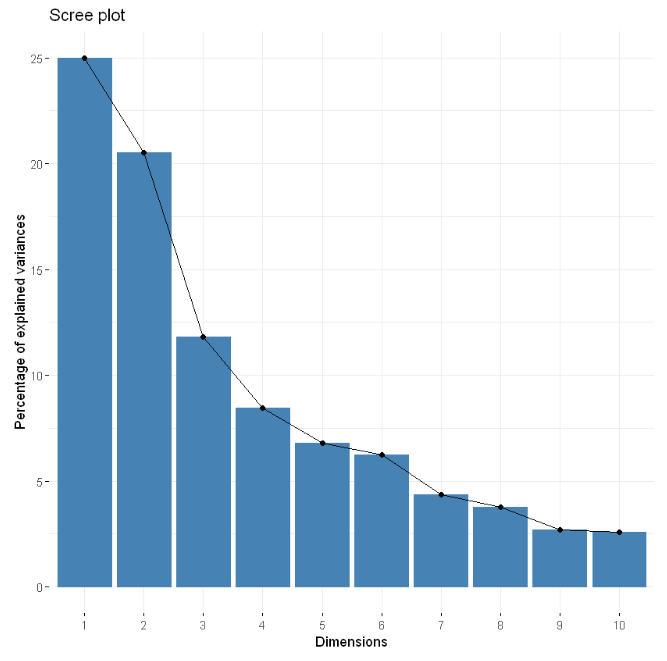

Looking at the graph above and the table below, we see that 2 components explain almost half of the variance and that 7 components explain 83% of the variance.

In [ ]:
res_FAMD_SanJose_2$eig

# Image 2

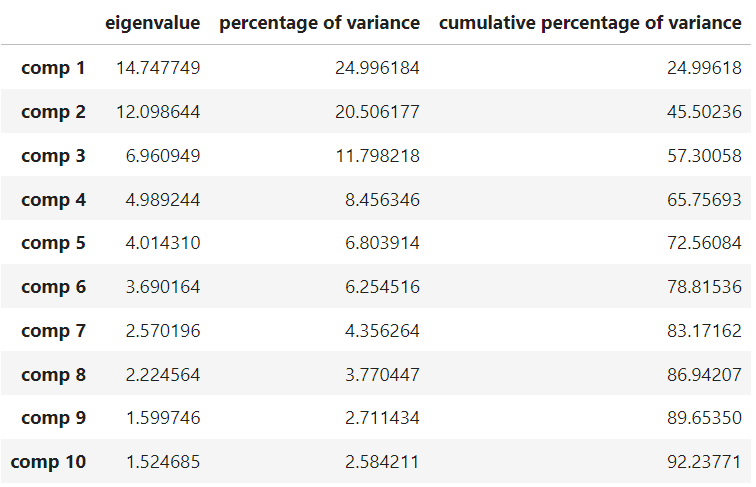

In [ ]:
options(repr.plot.width=16, repr.plot.height=16)
nb.cols <- 11 #districts
mycolors <-  colorRampPalette(c('green',"red", "yellow",'blue', "pink"))(nb.cols)


a=fviz_mfa_ind(res_FAMD_SanJose_2, axes=c(1,2),
             habillage = "District", # color by groups 
             palette = mycolors,
             addEllipses = TRUE, ellipse.type = "confidence", 
             repel = TRUE # Avoid text overlapping
             )

b=fviz_famd_var(res_FAMD_SanJose_2, "quanti.var", col.var = "cos2", axes = c(1,2),
             gradient.cols = c("#00AFBB", "#E7B800", "#FC4E07"),
             repel = TRUE) + xlim(-1,1) + ylim(-1,1)

c=fviz_mfa_ind(res_FAMD_SanJose_2, axes=c(3,4),
             habillage = "District", # color by groups 
             palette = mycolors,
             addEllipses = TRUE, ellipse.type = "confidence", 
             repel = TRUE # Avoid text overlapping
             )

d=fviz_famd_var(res_FAMD_SanJose_2, "quanti.var", col.var = "cos2", axes = c(3,4),
             gradient.cols = c("#00AFBB", "#E7B800", "#FC4E07"),
             repel = TRUE) + xlim(-1,1) + ylim(-1,1)

gridExtra::grid.arrange(a,b,c,d, ncol=2) 

# Image 3

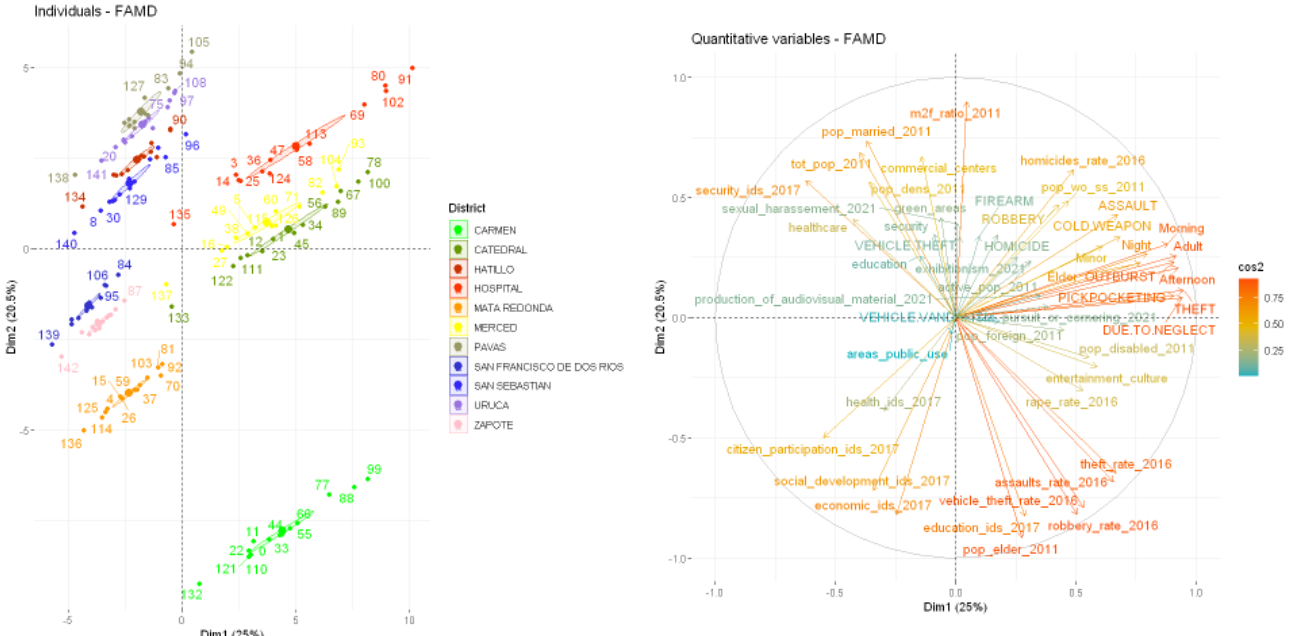

# Image 4

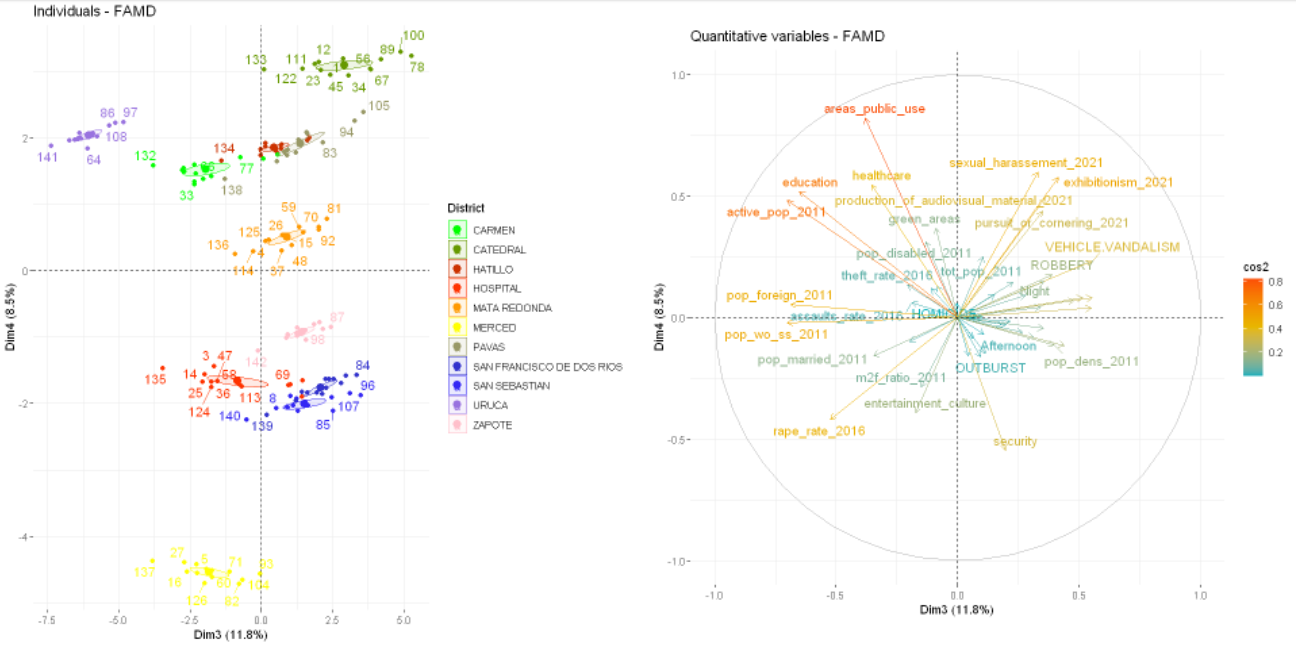

We can see that FAMD is a very powerfull tool to cluster the different districts according to its security levels and demographic information and visualized here only with the first 4 dimensions. In particular, we can see that FAMD analysis separates using the first dimension the districts that have hightest crime rates against women reported  and splits using the second dimension the districts with better general socio-economic figures. For instance, Hospital district is placed in the first quadrant because has high rates of crimes and poor socio-economic indexes.   Below we can confirm the contribution of each variable to the first 4 dimensions. The first dimension has a high correlation with the number of different crimes reported against women while the second dimension majorly correlates with socio-economic, demographic information.

In [ ]:
options(repr.plot.width=16, repr.plot.height=8)
# Contribution to the first dimension
fviz_contrib(res_FAMD_SanJose_2, "var", axes = 1)
# Contribution to the second dimension
fviz_contrib(res_FAMD_SanJose_2, "var", axes = 2)
# Contribution to the third dimension
fviz_contrib(res_FAMD_SanJose_2, "var", axes = 3)
# Contribution to the fourth dimension
fviz_contrib(res_FAMD_SanJose_2, "var", axes = 4)

# Image 5
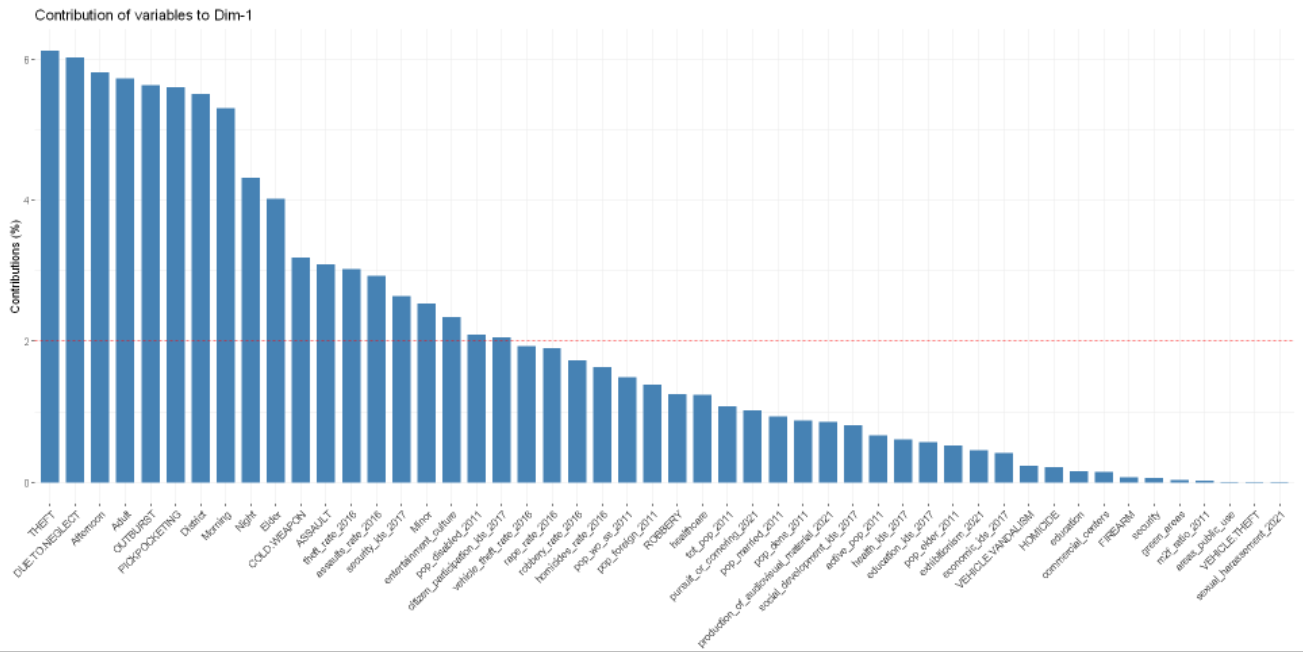
# Image 6
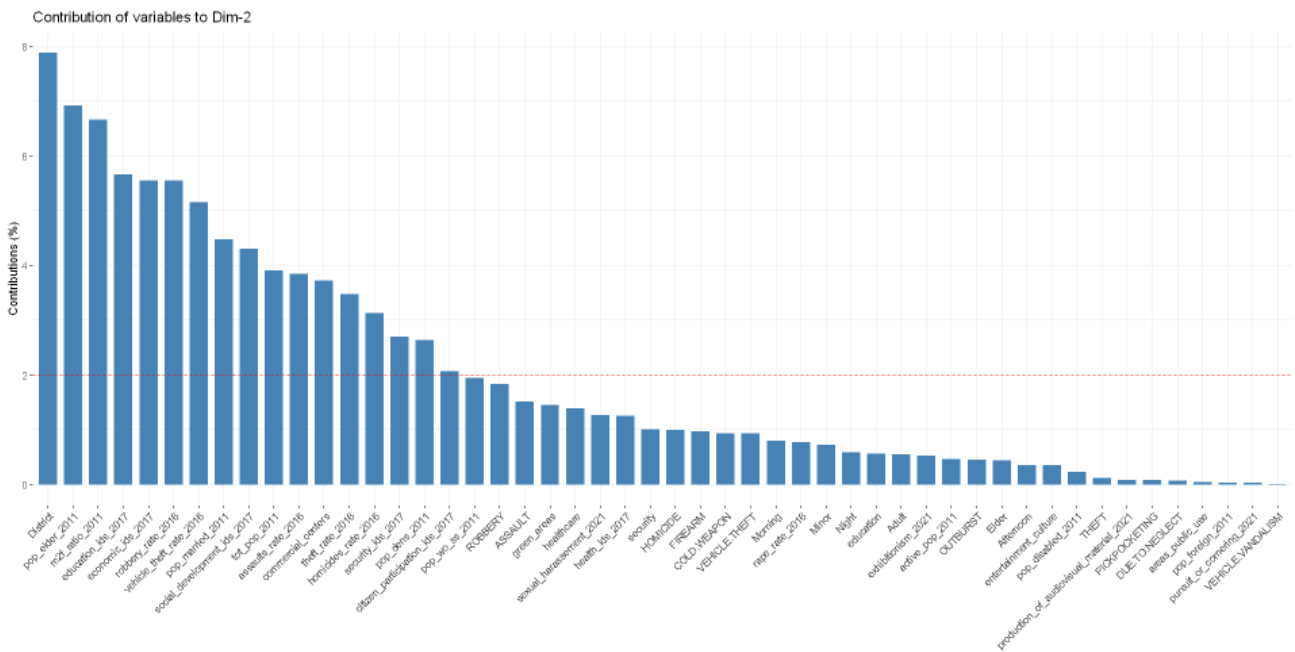
# Image 7
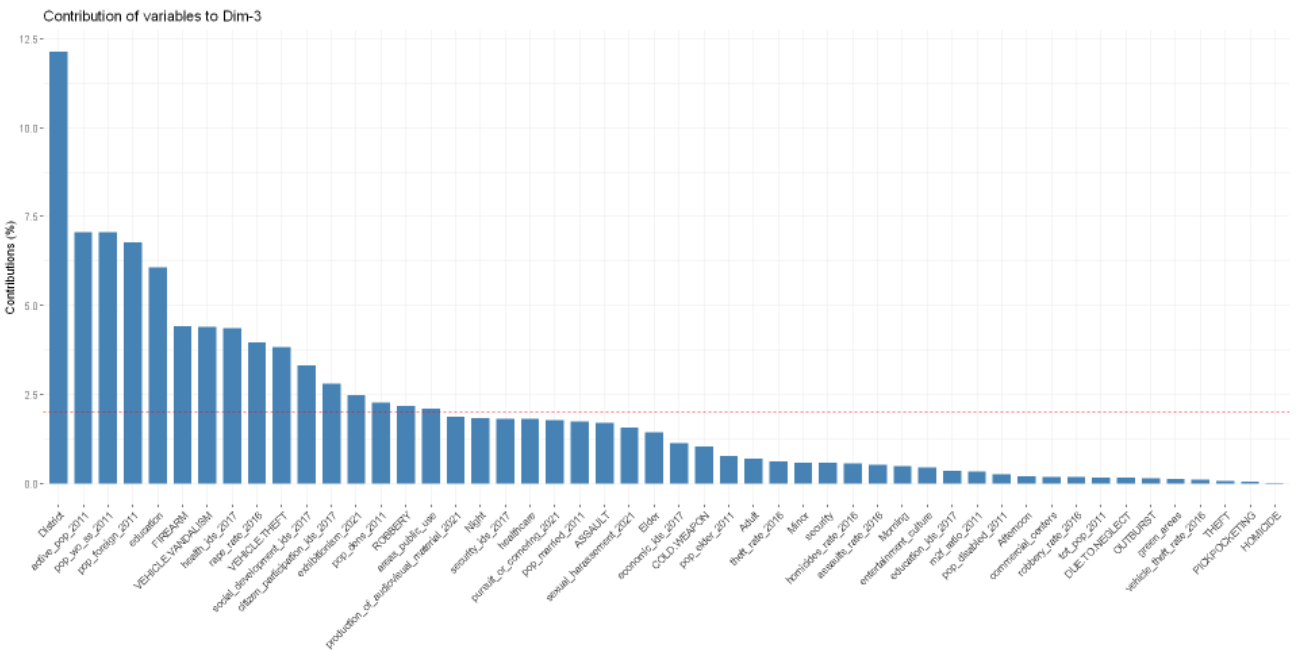
# Image 8
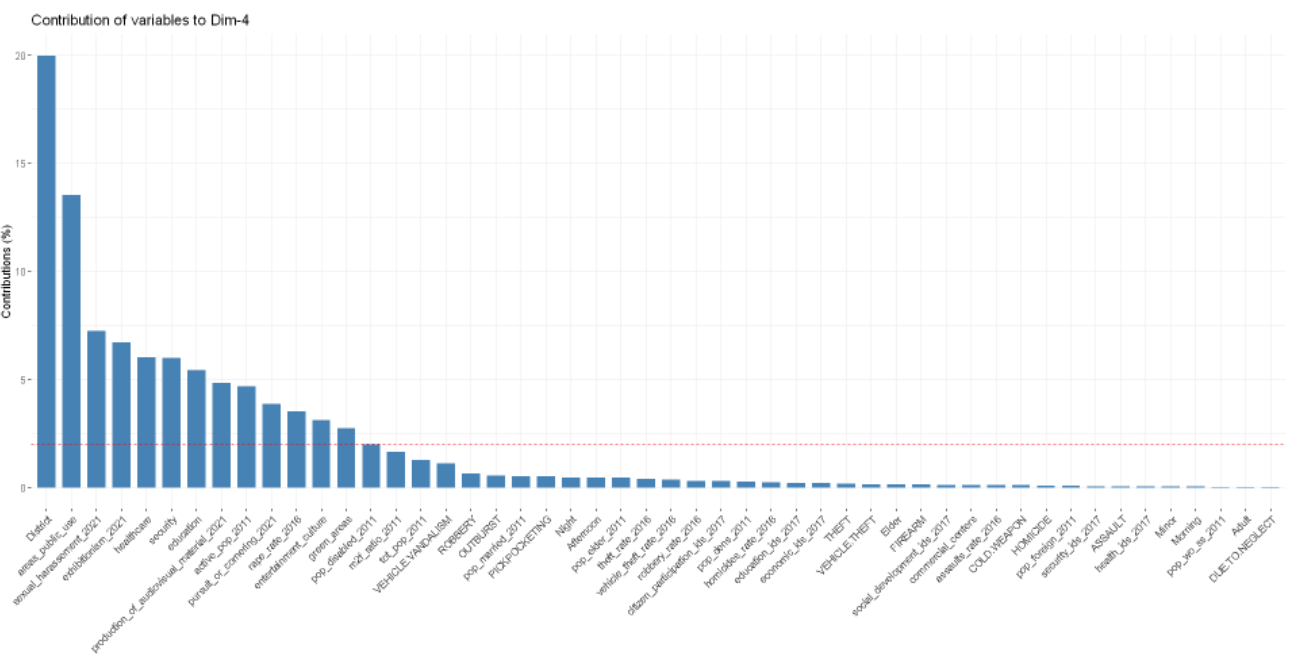

Because sexual harrasment information is only available for the year of 2021 and the information is very sparse for the San Jose canton, we decided to perform the same FAMD analysis without those variables, in order to reduce any possible bias.

In [ ]:
# same analysis but without 2021 harrassment data
year_without2021data_= subset(year, select = -c(sexual_harassement_2021, exhibitionism_2021, pursuit_or_cornering_2021, production_of_audiovisual_material_2021))
res_FAMD_SanJose_3 = FAMD(year_without2021data_, ncp = 10, sup.var=1, ind.sup = NULL, graph = TRUE)

fviz_screeplot(res_FAMD_SanJose_3)

# Image 9

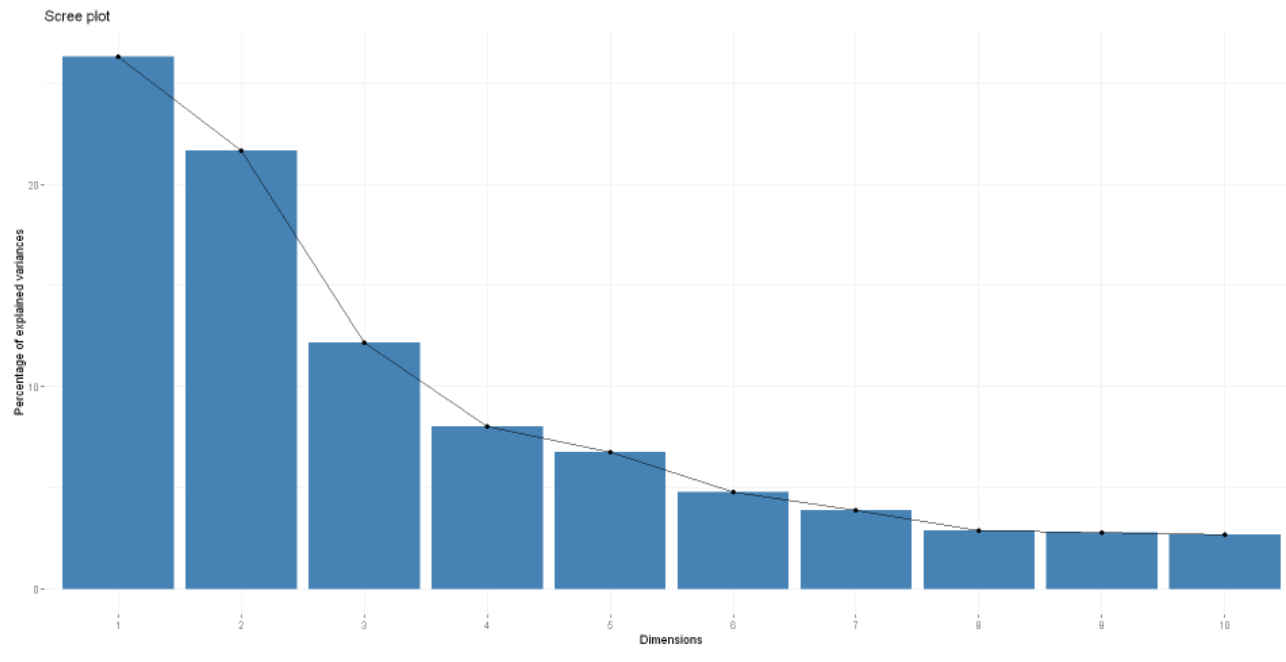

Looking at the new results, we can use 6 dimensions now to explain 80% of the variance.

This translates in a reduction of 86% in terms of features used (when comparing to the original number of features used).

In [ ]:
res_FAMD_SanJose_3$eig

# Image 10

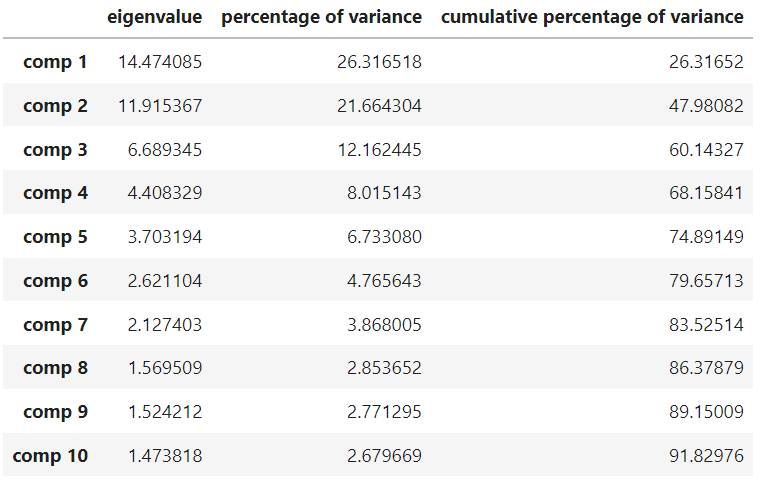

In [ ]:
# Define the number of colors you want
options(repr.plot.width=16, repr.plot.height=16)
nb.cols <- 11 #districts
mycolors <-  colorRampPalette(c('green',"red", "yellow",'blue', "pink"))(nb.cols)


a=fviz_mfa_ind(res_FAMD_SanJose_3, axes=c(1,2),
             habillage = "District", # color by groups 
             palette = mycolors,
             addEllipses = TRUE, ellipse.type = "confidence", 
             repel = TRUE # Avoid text overlapping
             )

b=fviz_famd_var(res_FAMD_SanJose_3, "quanti.var", col.var = "cos2", axes = c(1,2),
             gradient.cols = c("#00AFBB", "#E7B800", "#FC4E07"),
             repel = TRUE) + xlim(-1,1) + ylim(-1,1)

c=fviz_mfa_ind(res_FAMD_SanJose_3, axes=c(3,4),
             habillage = "District", # color by groups 
             palette = mycolors,
             addEllipses = TRUE, ellipse.type = "confidence", 
             repel = TRUE # Avoid text overlapping
             )

d=fviz_famd_var(res_FAMD_SanJose_3, "quanti.var", col.var = "cos2", axes = c(3,4),
             gradient.cols = c("#00AFBB", "#E7B800", "#FC4E07"),
             repel = TRUE) + xlim(-1,1) + ylim(-1,1)

gridExtra::grid.arrange(a,b,c,d, ncol=2) 

# Image 11

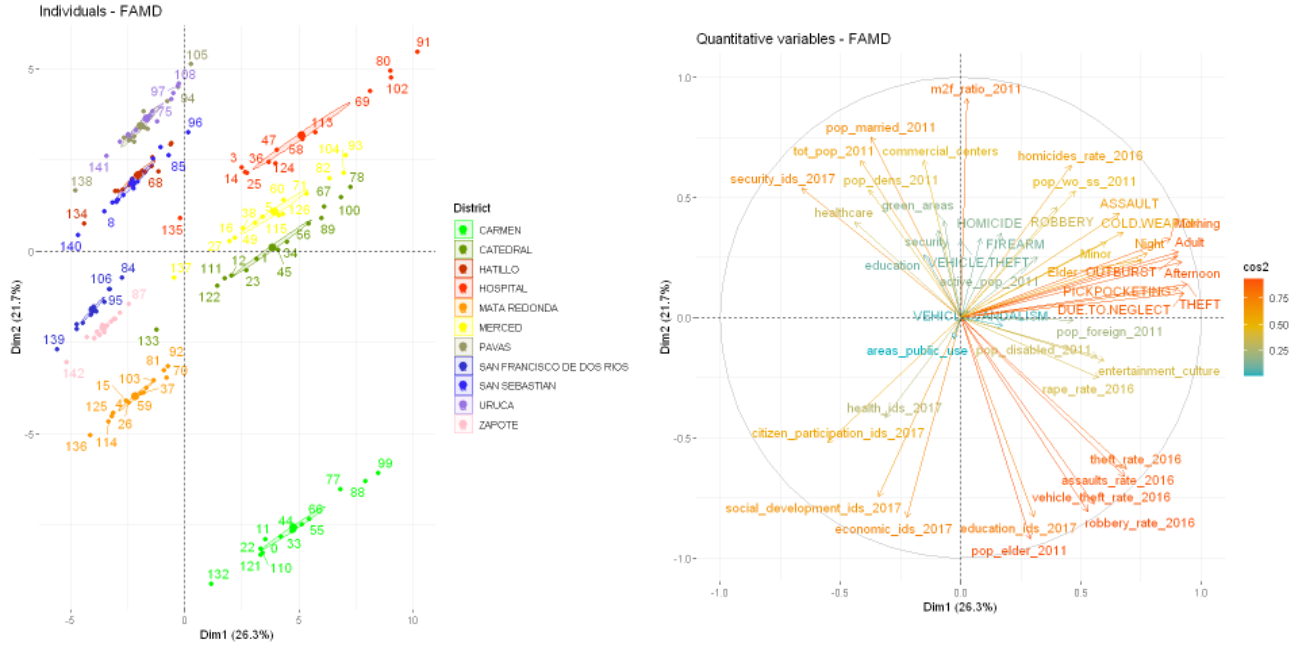

# Image 12

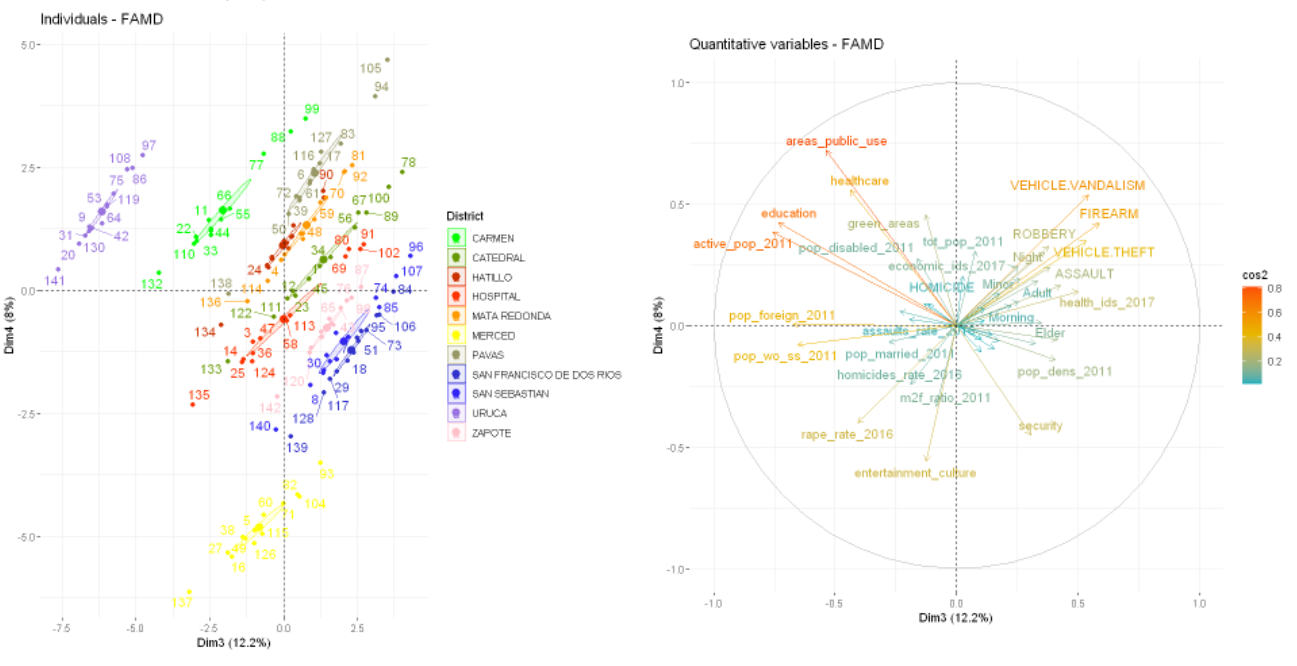

FAMD showed to be a good tool to fairly evaluate district security in a certain year and when a large number of features are considered. This way we can be fair on the calculation of the index without giving any special relevance to a particular variable.

We are using this approach to calculate new variables that are going to be used to calculate the security index for every district from San Jose, in a particular year, using a simple linear combination of the dimensions.

In [ ]:
year_without2021data_in_newdimenions_SanJose_3 = predict.FAMD(res_FAMD_SanJose_3, year_without2021data_) # year categorical

# add new columns (6 dimensions chosen) to original dataset
year_without2021data_$PCA1=year_without2021data_in_newdimenions_SanJose_3$coord[,1]
year_without2021data_$PCA2=year_without2021data_in_newdimenions_SanJose_3$coord[,2]
year_without2021data_$PCA3=year_without2021data_in_newdimenions_SanJose_3$coord[,3]
year_without2021data_$PCA4=year_without2021data_in_newdimenions_SanJose_3$coord[,4]
year_without2021data_$PCA5=year_without2021data_in_newdimenions_SanJose_3$coord[,5]
year_without2021data_$PCA6=year_without2021data_in_newdimenions_SanJose_3$coord[,6]

# for later index creation and respective prediction with a python kernel
write.csv(year_without2021data_,"year_without2021data_.csv", row.names = FALSE)

We will now analyze the quarterly data.

In [ ]:
# analysis for quarter
trimester_without2021data_= subset(year_trimester, select = -c(sexual_harassement_2021, exhibitionism_2021, pursuit_or_cornering_2021, production_of_audiovisual_material_2021 ))
res_FAMD_SanJose_trimester = FAMD(trimester_without2021data_, ncp = 10, sup.var=c(1,3), ind.sup = NULL, graph = TRUE)

In [ ]:
res_FAMD_SanJose_trimester$eig # (7 variables explain 80% of the variance in the dataset)

For the quarterly data, we will use 7 components, as that's the mininmum number of components needed to explain 80% of the variance.

# Imagem 13

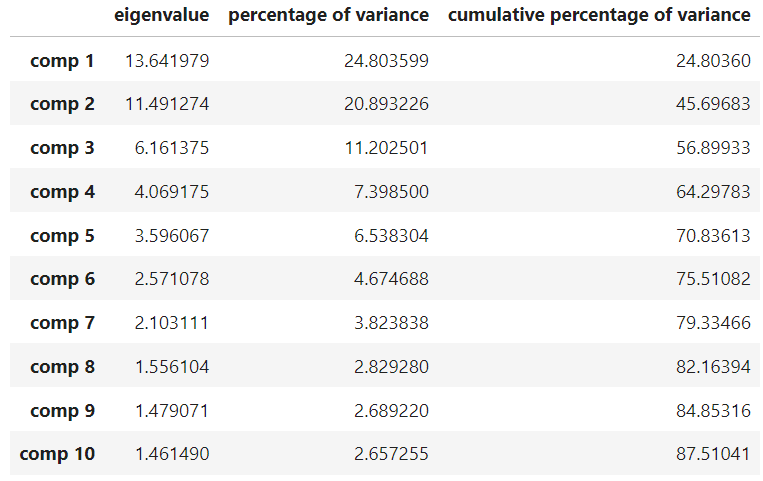

In [ ]:
options(repr.plot.width=16, repr.plot.height=8)
# Contribution to the first dimension
fviz_contrib(res_FAMD_SanJose_trimester, "var", axes = 1)
# Contribution to the second dimension
fviz_contrib(res_FAMD_SanJose_trimester, "var", axes = 2)
# Contribution to the third dimension
fviz_contrib(res_FAMD_SanJose_trimester, "var", axes = 3)
# Contribution to the fourth dimension
fviz_contrib(res_FAMD_SanJose_trimester, "var", axes = 4)

# Imagem 14

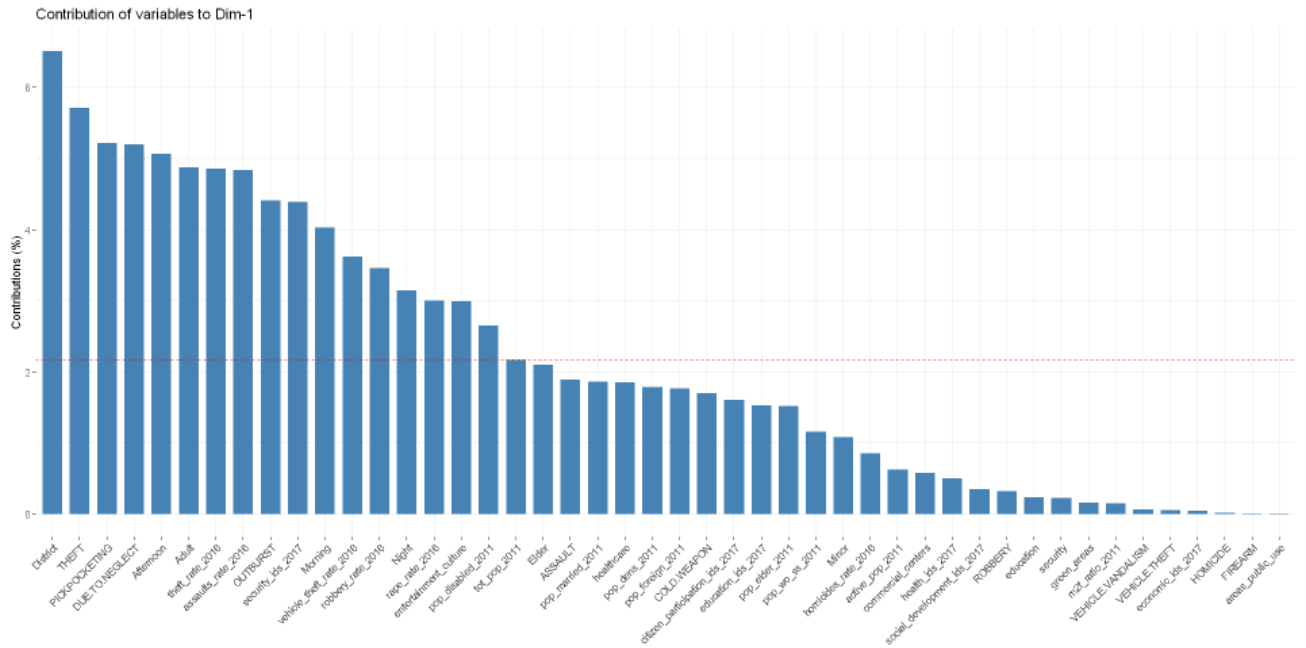

# Imagem 15

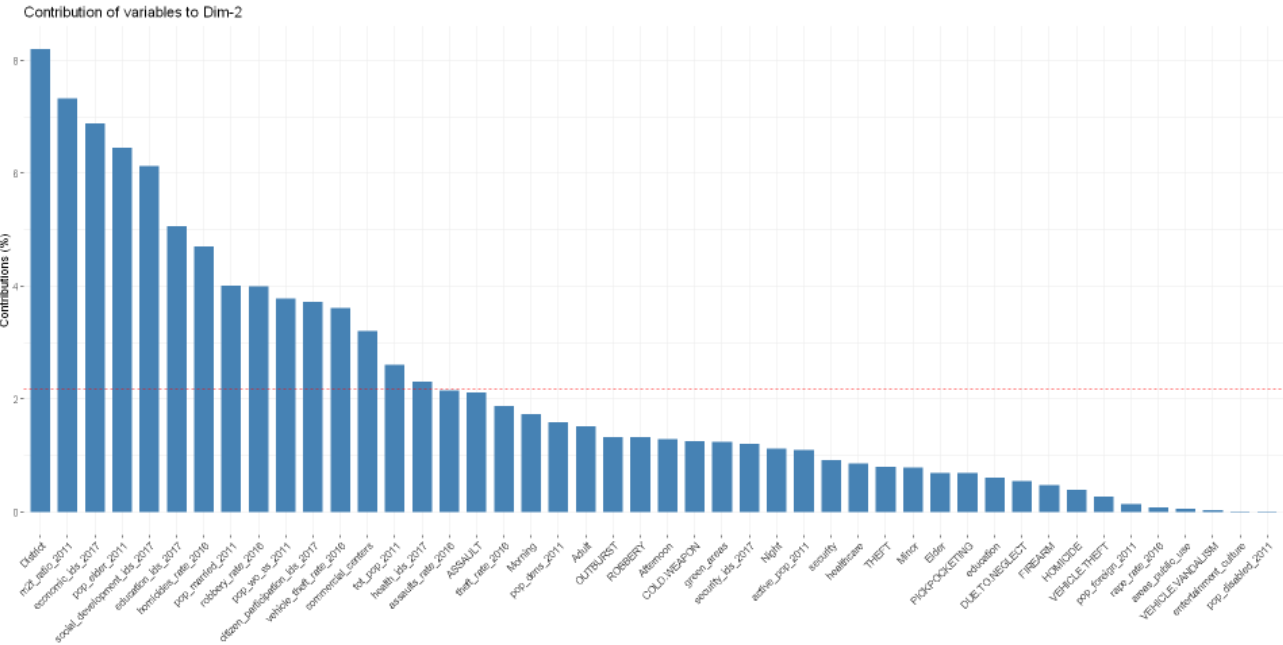

# Imagem 16

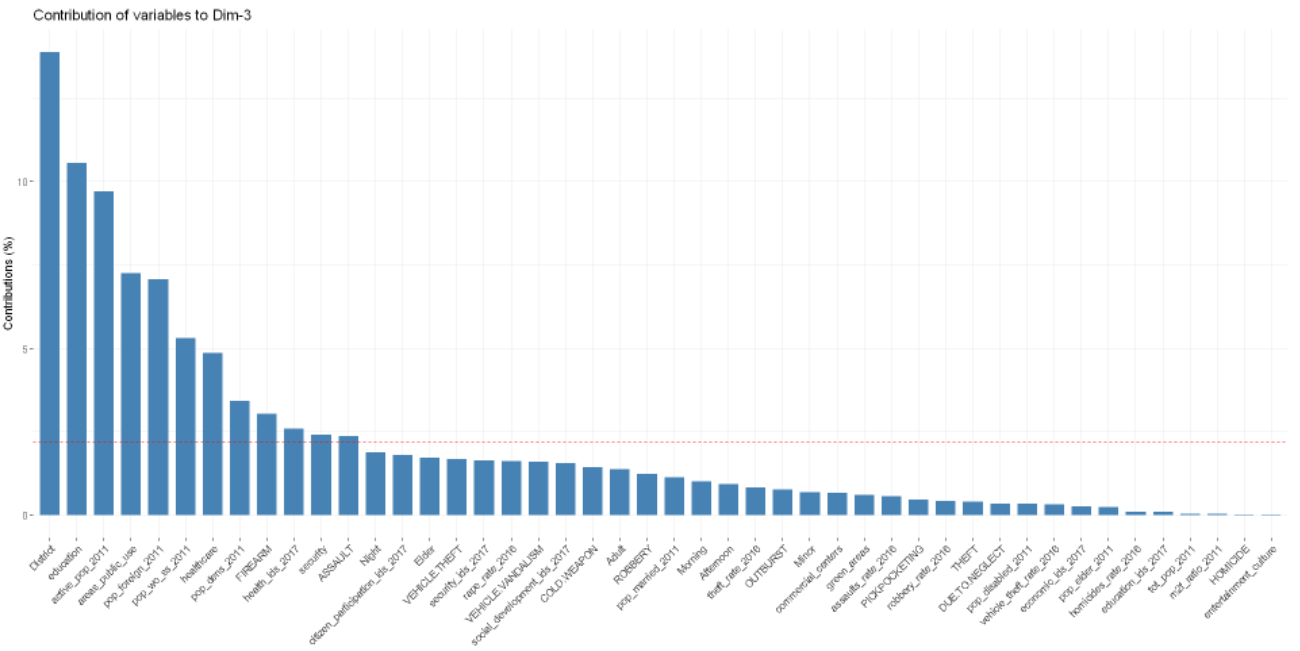

# Imagem 17

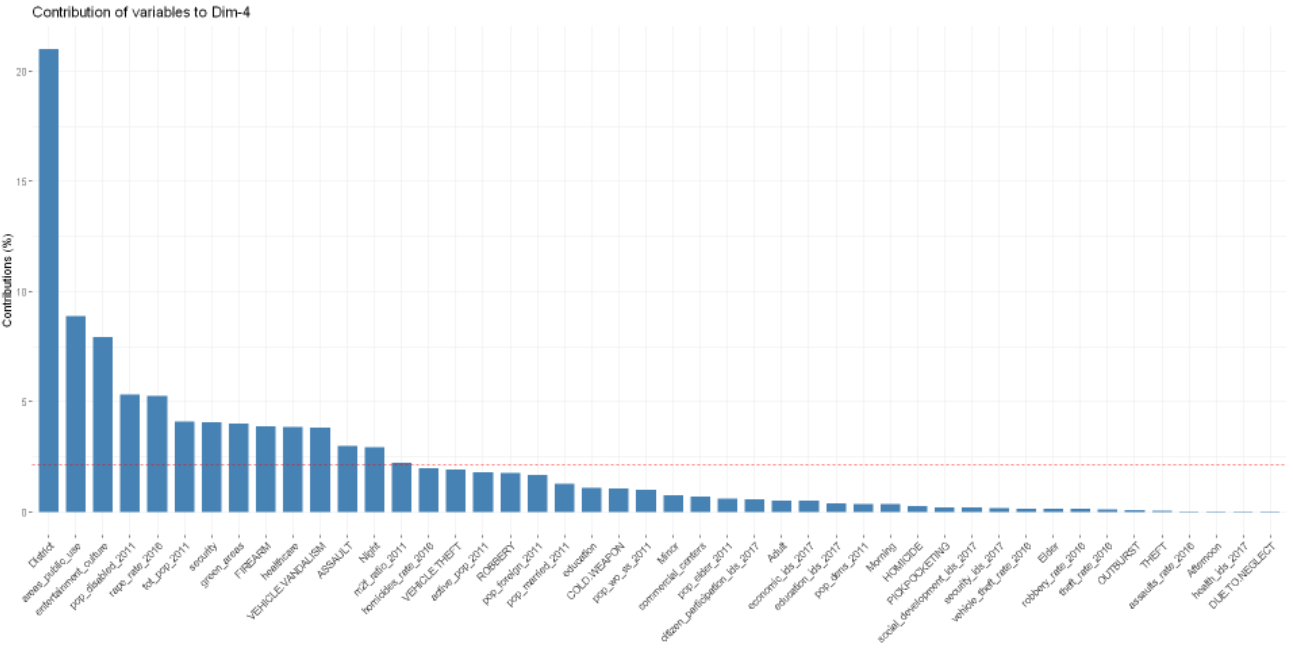

In [ ]:
trimester_without2021data_in_newdimenions_SanJose_= predict.FAMD(res_FAMD_SanJose_trimester, trimester_without2021data_) # year and quarter categorical

# add new columns (7 dimensions chosen) to original dataset
trimester_without2021data_$PCA1=trimester_without2021data_in_newdimenions_SanJose_$coord[,1]
trimester_without2021data_$PCA2=trimester_without2021data_in_newdimenions_SanJose_$coord[,2]
trimester_without2021data_$PCA3=trimester_without2021data_in_newdimenions_SanJose_$coord[,3]
trimester_without2021data_$PCA4=trimester_without2021data_in_newdimenions_SanJose_$coord[,4]
trimester_without2021data_$PCA5=trimester_without2021data_in_newdimenions_SanJose_$coord[,5]
trimester_without2021data_$PCA6=trimester_without2021data_in_newdimenions_SanJose_$coord[,6]
trimester_without2021data_$PCA7=trimester_without2021data_in_newdimenions_SanJose_$coord[,7]

# for later index creation and respective prediction with a python kernel
write.csv(trimester_without2021data_,"trimester_without2021data_.csv", row.names = FALSE)

In [7]:
# reading data with results from PCA Analysis

trimester_data = pd.read_csv('trimester_without2021data_.csv')
year_data = pd.read_csv('year_without2021data_.csv')

Looking at the results from the FAMD analysis, we created our **Women Security Index** (WSI) thinking foremost of explainability. Even though we'd need 6 or 7 components to explain 80% of the variance, we decided to only use the first 2 components. we thought that this way our index would be more explainable and people would understand it easily.

The formulas for the index are:

WSI_year = 2*PCA1 + |PCA2|

WSI_quarter = 2*PCA1 + |PCA2|

In [9]:
year_data['WSI_year'] = 2 * year_data['PCA1'] + abs(year_data['PCA2']) #+ year_data['PCA3'] + year_data['PCA4'] + year_data['PCA5'] + year_data['PCA6']

trimester_data['WSI_trimester'] = 2 * trimester_data['PCA1'] + abs(trimester_data['PCA2']) #+ trimester_data['PCA3'] + trimester_data['PCA4'] + trimester_data['PCA5'] + trimester_data['PCA6'] + trimester_data['PCA7']

In [10]:
# normalize the index
year_data['WSI_year'] = sklearn.preprocessing.minmax_scale(year_data['WSI_year'], feature_range=(0, 1), axis=0, copy=True)

trimester_data['WSI_trimester'] = sklearn.preprocessing.minmax_scale(trimester_data['WSI_trimester'], feature_range=(0, 1), axis=0, copy=True)

## Modelling

We decided to use the LightGBM model. 

This decision was made because in the previous challenge, where we also worked with time series data, we tested different models, namely: Holt-Winters, SARIMA, LSTM, XGBoost and LightGBM and LightGBM presented the best results. So as we didn't have much time, we decided that we would start by using this model and if we had more time then we would also try other models.


The next cell contains all the functions used in the development of the LightGBM model.

First we present the functions used to train the model.

We performed hyperparameter optimization on all models and concluded that it didn't improve the results (More details on this will be provided later).

Furthermore, as we realized that our models were mostly underestimated, we decided to use an asymmetric loss that penalizes these situations more and this way we were able to solve this problem. Also, when we think about the problem from a business point of view, it is preferable that we have a model with a little overestimation, as it is preferable to have an index saying that a district is a little more dangerous than it really is than the other way around.

In [69]:
def shifted_features(df: pd.DataFrame, groupby_vars: list, variable: str) -> pd.DataFrame:
    """
    Shifts time-relevant columns by 5 year to allow the algorithm to learn time dependencies.

    Args:
        df (pd.DataFrame): input data for each component
        groupby_vars (list): list with the variables to be used in the group by
        variable (str): time-relevant column

    Returns:
        pd.DataFrame: input data + time based features
    """
    
    df_new = pd.DataFrame()
    for i in range(1, 6):
        df[variable + "_shifted-" + str(i)] = df.groupby(groupby_vars)[variable].shift(i)

    df_new = pd.concat([df_new, df])

    return df_new


def split_data(df: pd.DataFrame) -> tuple:
    """splits data into train, test, val 

    Args:
        df (pd.DataFrame): data

    Returns:
        tuple: data splitted into train, val, test
    """

    train = df.loc[(df['year'] < 2021), :]
    val = df.loc[(df['year'] == 2021), :]
    test = df.loc[(df['year'] == 2022), :]

    return train, val, test


hpo_params_lgb = {
    "num_leaves": np.arange(20, 3000, 20),
    "max_depth": [1, 3, 6, 10, 20],
    "min_data_in_leaf": np.arange(200, 10000, 100),
    "n_estimators": np.arange(100, 5000, 100),
    "learning_rate": [0.1, 0.15, 0.2, 0.5, 1], 
    "lambda_l1": np.arange(0, 100, 5),
    "lambda_l2": np.arange(0, 100, 5),
    "min_gain_to_split": [0.1, 0.15, 0.2, 0.25, 0.5, 1],
    "bagging_fraction": np.arange(0.3, 1.0, 0.1),
    "bagging_freq": [1],
    "feature_fraction": np.arange(0.3, 1.0, 0.1)
}


class NpEncoder(json.JSONEncoder):
    """
    Auxiliary function to save hpo results.
    """
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        if isinstance(obj, np.floating):
            return float(obj)
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return super(NpEncoder, self).default(obj)

In [76]:
def tune_model_lgb(X_train: pd.DataFrame, 
                    Y_train: pd.DataFrame, 
                    X_val: pd.DataFrame, 
                    Y_val: pd.DataFrame) -> None:
    """
    Performs HPO.

    Args:
        X_train (pd.DataFrame): train data
        Y_train (pd.DataFrame): target train data
        X_val (pd.DataFrame): val data (for early stopping)
        Y_val (pd.DataFrame): target val data (for early stopping)

    Returns:
        None (best params are stored on disk)
    """
    
    eval_set = [(X_val, Y_val)]
    
    mdl = lgb.LGBMRegressor(objective='rmse',
                        n_estimators=5000,
                        boosting_type='gbdt',
                        random_state=42)

    clf = RandomizedSearchCV(estimator=mdl,
                             param_distributions=hpo_params_lgb,
                             scoring='neg_mean_squared_error',
                             n_iter=20,
                             verbose=3,
                             cv=5,
                             random_state=42)
    
    clf.fit(X_train,
            Y_train,
            eval_set=eval_set,
            early_stopping_rounds=20)

    with open("results/best_params.txt", "w") as file:
        file.write(json.dumps(clf.best_params_, cls=NpEncoder))


class AsymmetricLoss:
    """
    Class that provides asymmetric custom loss functions for LightGBM.
    """

    def __init__(self):
        self.penalty = PENALTY

    def custom_asymmetric_train(self, y_pred: list, dataset_true: lgb.Dataset) -> tuple:
        """
        Custom loss function for model training, penalizes underforecasting.

        Args:
            y_pred (list): predictions
            dataset_true (lgb.Dataset): LGBM dataset containing true values

        Returns:
            tuple: gradient and hessian
        """
        y_true = dataset_true.get_label()
        residual = (y_true - y_pred).astype("float")
        grad = np.where(residual > 0, -2 * self.penalty * residual, -2 * residual)
        hess = np.where(residual > 0, 2 * self.penalty, 2.0)
        return grad, hess

    def custom_asymmetric_valid(self, y_pred: list, dataset_true: lgb.Dataset) -> tuple:
        """
        Custom loss function for model validation, penalizes underforecasting
        
        Args:
            y_pred (list):  predictions
            dataset_true (lgb.Dataset): LGBM dataset containing true values
        
        Returns:
            tuple: name of metric, loss, boolean indicating whether higher is better
        """
        y_true = dataset_true.get_label()
        residual = (y_true - y_pred).astype("float")
        loss = np.where(residual > 0, (residual**2) * self.penalty, residual**2)
        return "custom_asymmetric_eval", np.mean(loss), False


def train_model_lgb(X_train: pd.DataFrame, 
                    Y_train: pd.DataFrame, 
                    X_val: pd.DataFrame, 
                    Y_val: pd.DataFrame) -> lgb.Booster:
    """
    Trains and validates an LightGBM Model with early stopping.

    Args:
        X_train (pd.DataFrame): train data
        Y_train (pd.DataFrame): train target
        X_val (pd.DataFrame): val data (for early stopping)
        Y_val (pd.DataFrame): val target (for early stopping)

    Returns:
        lgb.Booster: fitted model
    """
    
    cols = X_train.columns.to_list()
    lgbtrain = lgb.Dataset(data=X_train, label=Y_train, feature_name=cols)
    lgbval = lgb.Dataset(data=X_val, label=Y_val, reference=lgbtrain, feature_name=cols)

    try:
       #print("loading best params")
       f = open("results/best_params_" + DF_TYPE + ".txt", "r")
       lgb_params = json.loads(str(f.read()))
       lgb_params["seed"] = 42
       lgb_params["verbose"] = -1
       f.close()
    except FileNotFoundError:
        #print("could not load best params")
        lgb_params = {
            "config": "train",
            "objective": "regression_l1",
            "boosting": "gbdt",
            "num_iterations": 5000,
            "learning_rate": 0.05,
            "num_leaves": 60,
            "tree_learner": "data_parallel",
            "num_threads": 16,
            "seed": 42,
            "deterministic": True,
            "bagging_fraction": 0.6,
            "bagging_freq": 1,
            "feature_fraction": 0.9,
            "feature_fraction_bynode": 0.9,
            "early_stopping_round": 50,
            "max_depth": 20,
            "verbose": -1
        }

    al = AsymmetricLoss()
    model = lgb.train(lgb_params,
                    lgbtrain,
                    valid_sets=[lgbval],
                    fobj=al.custom_asymmetric_train,
                    feval=al.custom_asymmetric_valid,
                    verbose_eval=-1)
    

    return model

Finally, we have the functions used to evaluate the results.

In [71]:
def eval_model(model: lgb.Booster, 
               X_test: pd.DataFrame, 
               Y_test: pd.DataFrame) -> list:
    """
    Evaluates model with regards to test data.

    Args:
        model (lgb.Booster): model to be evalued
        X_test (pd.DataFrame): test data
        Y_test (pd.DataFrame): test target
    
    Returns:
        list: list of eval metrics
    """
    preds = model.predict(X_test)

    return [mean_absolute_error(preds, Y_test), 
        mean_absolute_percentage_error(preds, Y_test) * 100,
        preds]


def plot_images(model: lgb.Booster,
                df: pd.DataFrame) -> None:
    """
    Plot some graphs for the test set for visual inspection.

    Args:
        model (lgb.Booster): fitted model
        df (pd.DataFrame): test dataset
    """
    
    # image 1 - predictions vs true value for each district
    df.plot(x="District", y=["True WSI", "Predicted WSI"], kind="barh", figsize=(10, 10))
    plt.title('Comparison between true and predicted values for each district', fontsize=20)

    # image 2 - feature importance
    gain = model.feature_importance('gain')
    feat_imp = pd.DataFrame({'feature': model.feature_name(),
                             'split': model.feature_importance('split'),
                             'gain': 100 * gain / gain.sum()}).sort_values('gain', ascending=False)
    
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="gain", y="feature", data=feat_imp[0:25])
    plt.xlabel("Gain")
    plt.ylabel('Features')
    plt.title(f'Feature importance', fontsize=20)
    plt.tight_layout()

    # image 3 - scatterplot
    plt.figure(figsize=(24,8))
    plt.scatter(Y_test, test['Predicted WSI'], c="steelblue")
    plt.plot( [0,1],[0,1], c='dimgrey' )
    plt.xlabel('True values')
    plt.ylabel('Predicted values')
    plt.title(f'Comparison between true and predicted values', fontsize=20)

Our approach was to build a model for two different time forecasts - yearly and trimesterly - thus ending up with 2 models.

First, we build a model for the yearly index forecast for each district.

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[36]	valid_0's custom_asymmetric_eval: 0.00198574
 ******************************************** 
 RESULTS OF YEARLY MODEL
 ******************************************** 
Mean Absolute Error: 0.13218170354980477
Mean Absolute Percentage Error: 54.69248126996169


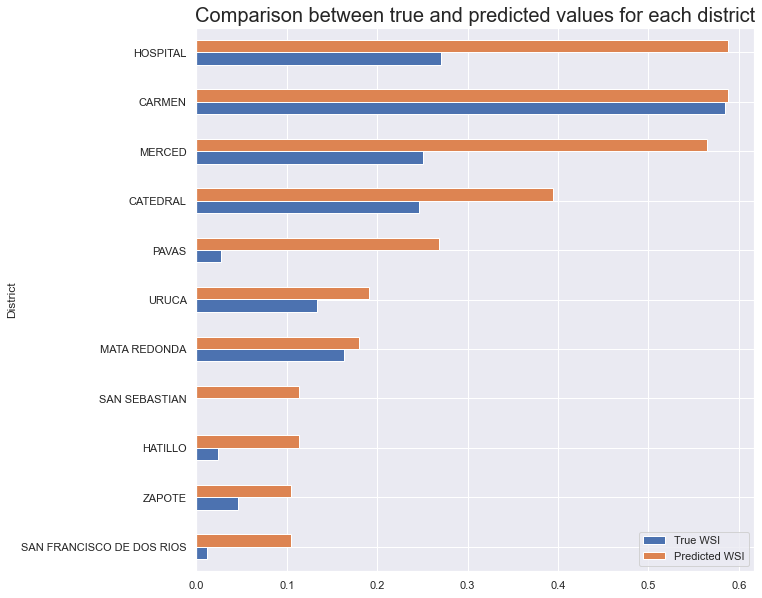

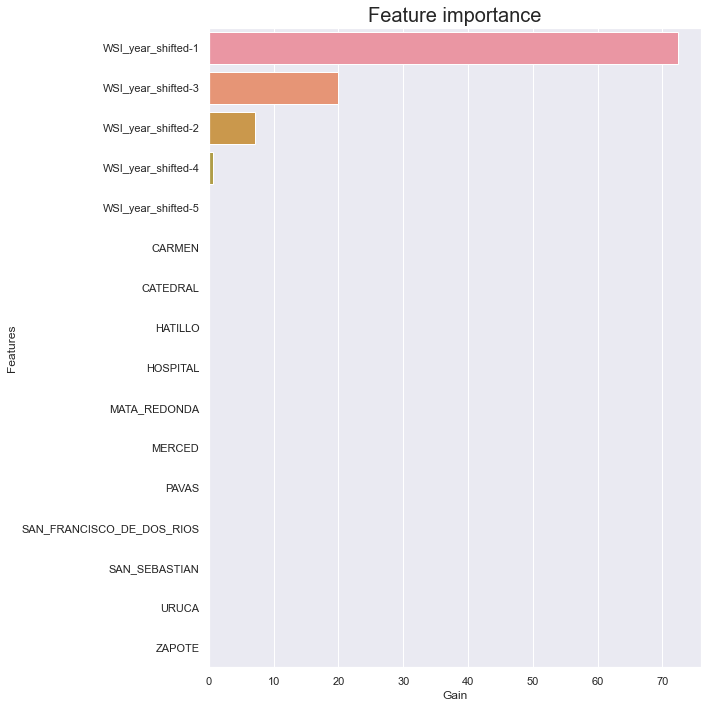

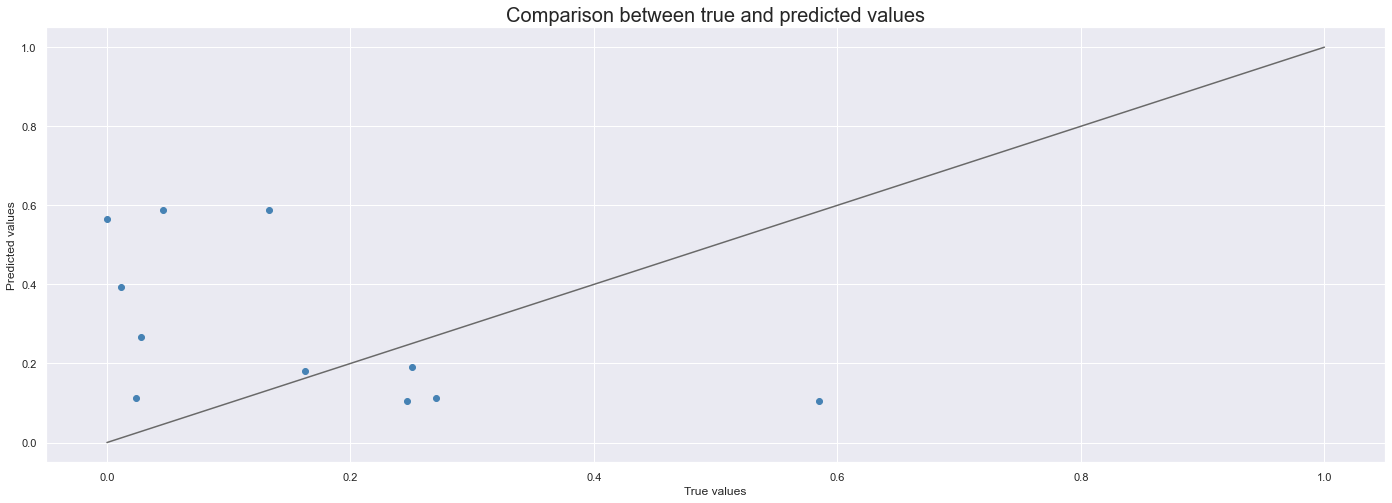

In [99]:
DF_TYPE = "YEARLY"
PENALTY = 1
TUNE = False

# prepare the dataset
df = year_data[['year', 'District', 'WSI_year']]

df = df.sort_values(by=['District', 'year'])
df = shifted_features(df, ['District'], 'WSI_year')

dummies_district = pd.get_dummies(df['District'])
df = pd.concat([df, dummies_district], axis=1)

# create the train, test and val splits
train, val, test = split_data(df)

Y_train = train['WSI_year']
X_train = train.drop(['WSI_year', 'year', 'District'], axis=1)

Y_val = val['WSI_year']
X_val = val.drop(['WSI_year', 'year', 'District'], axis=1)

Y_test = test['WSI_year']
X_test = test.drop(['WSI_year', 'year', 'District'], axis=1)

# train the model
if TUNE:
    tune_model_lgb(X_train, Y_train, X_val, Y_val)
else:
    model = train_model_lgb(X_train, Y_train, X_val, Y_val)
    metrics = eval_model(model, X_test, Y_test)

    # used to create the graphs
    test = test[['year', 'District', 'WSI_year']] \
        .assign(Predicted_WSI = metrics[2]) \
        .sort_values('Predicted_WSI') \
        .rename(columns={
            'WSI_year': 'True WSI',
            'Predicted_WSI': 'Predicted WSI',
        })

    # test.to_csv(f'results/{DF_TYPE}_predsLGBM.csv', sep=",")
    print(" ******************************************** ")
    print(f" RESULTS OF {DF_TYPE} MODEL")
    print(" ******************************************** ")
    print(f"Mean Absolute Error: {metrics[0]}")
    print(f"Mean Absolute Percentage Error: {metrics[1]}")
    plot_images(model, test)

Looking at the results, it is possible to see that the value of the index in the previous 4 years are important to predict the value of the index of the following year, with the value of the previous year being the most relevant. <br>
And it is precisely because these characteristics are the most important for the model that it is predicting HOSPITAL as the most dangerous district in 2021 - because in 2019 and 2018 Hospital was more dangerous (had a higher WSI) than Carmen. <br>
Fortunately, Hospital district had a large decrease in the index and therefore the model was not able to predict as it is not in line with the trend. <br>
Despite this, the model was able to correctly predict the four main dangerous districts: Carmen, Hospital, Merced and Cathedral.

Next, we have the model that does the trimesterly forecast for each district.

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[41]	valid_0's custom_asymmetric_eval: 0.00311173
 ******************************************** 
 RESULTS OF TRIMESTERLY MODEL
 ******************************************** 
Mean Absolute Error: 0.06779671847560896
Mean Absolute Percentage Error: 31.361007413385494


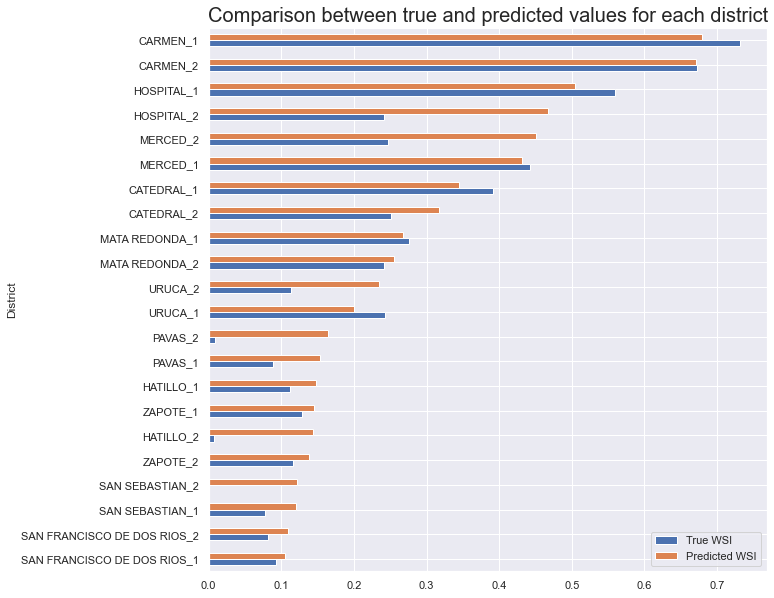

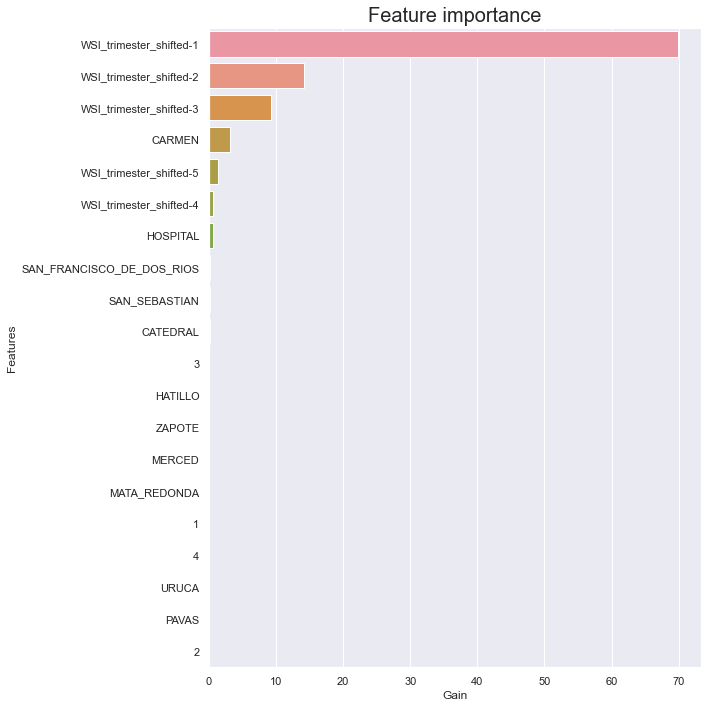

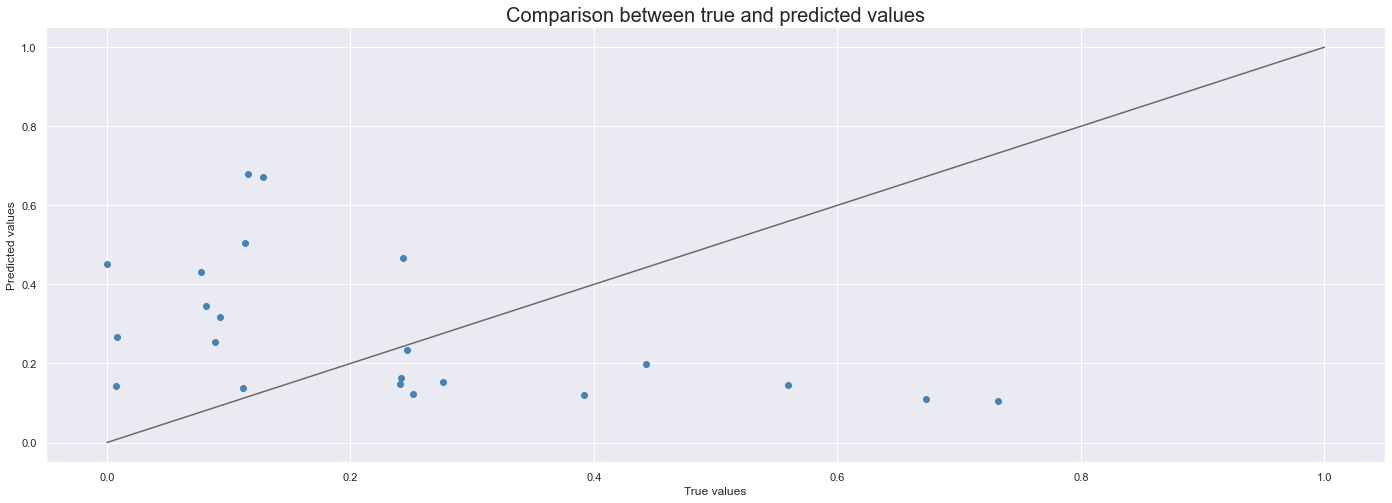

In [98]:
DF_TYPE = "TRIMESTERLY"
TUNE = False
PENALTY = 1

# prepare the dataset
df = trimester_data[['year', 'trimester', 'District', 'WSI_trimester']]

df = df.sort_values(by=['District', 'trimester'])
df = shifted_features(df, ['District', 'trimester'], 'WSI_trimester')

dummies_district = pd.get_dummies(df['District'])
df = pd.concat([df, dummies_district], axis=1)
dummies_trimester = pd.get_dummies(df['trimester'].apply(str))
df = pd.concat([df, dummies_trimester], axis=1)

# create the train, test and val splits
train, val, test = split_data(df)

Y_train = train['WSI_trimester']
X_train = train.drop(['WSI_trimester', 'year', 'trimester', 'District'], axis=1)
Y_val = val['WSI_trimester']
X_val = val.drop(['WSI_trimester', 'year', 'trimester', 'District'], axis=1)
Y_test = test['WSI_trimester']
X_test = test.drop(['WSI_trimester', 'year', 'trimester', 'District'], axis=1)

# train the model
if TUNE:
    tune_model_lgb(X_train, Y_train, X_val, Y_val)
else:
    model = train_model_lgb(X_train, Y_train, X_val, Y_val)
    metrics = eval_model(model, X_test, Y_test)
    
    # used to create the graphs
    test = test[['year', 'trimester', 'District', 'WSI_trimester']] \
        .assign(Predicted_WSI = metrics[2]) \
        .assign(District_ = test['District'] + '_' + test['trimester'].apply(str)) \
        .drop(['District'], axis=1) \
        .sort_values('Predicted_WSI') \
        .rename(columns={
            'WSI_trimester': 'True WSI',
            'Predicted_WSI': 'Predicted WSI',
            'District_': 'District'
        })

    # test.to_csv(f'results/{DF_TYPE}_predsLGBM.csv', sep=",")
    print(" ******************************************** ")
    print(f" RESULTS OF {DF_TYPE} MODEL")
    print(" ******************************************** ")
    print(f"Mean Absolute Error: {metrics[0]}")
    print(f"Mean Absolute Percentage Error: {metrics[1]}")
    plot_images(model, test)

This model gives importance to the index value in the previous five years, being that the previous year value is the most important. Besides, the index values of the Carmen district are also important for the model. <br>
For the first trimester, the model is almost always underforecasting, while for the second trimester it is almost always overeforecasting. This shows that it can be beneficial to train a model independently for each trimester, as they have different values, making it difficult for the model to correctly predict the values (Which we would do if we had more time). <br>
Despite this, the model is correctly predicting the four most dangerous districts in each trimester - Carmen, Hospital, Merced and Catedral.


The results obtained for each of the experiments performed are presented below. Although experiments 1 and 5 are the ones with the lowest error, in fact the predictions given by these models were flat, with values always close to zero, which shows that the model was not understanding the existing patterns in the data. For this reason, we decided not to use the models with the smallest error, but one that could understand the behavior of the data and presents a reasonable error. We ended up using the model resulting from experiment number 2.

In [97]:
#define header names
col_names = ["Parameters", "Yearly Model - MAPE (%)", "Trimesterly Model - MAPE (%)"]

#Results table
data_hourly = [
    ["1. Without HPO and without Assymmetric Loss", 7.192005650189749e+16, 1.0489181676563523e+17], 
    ["2. Without HPO and penalizing underforcasting with a penalty of 1", 55, 31],
    ["3. Without HPO and penalizing underforcasting with a penalty of 5", 59, 33],
    ["4. Without HPO and penalizing underforcasting with a penalty of 10", 59, 36],
    ["5. With HPO and without Assymmetric Loss", 9.192005650189749e+16,  3.0489181676563523e+17],
    ["6. With HPO and penalizing underforcasting with a penalty of 1", 61,  40]
]

#display table
print(tabulate(data_hourly, headers=col_names, tablefmt="fancy_grid"))

╒════════════════════════════════════════════════════════════════════╤═══════════════════════════╤════════════════════════════════╕
│ Parameters                                                         │   Yearly Model - MAPE (%) │   Trimesterly Model - MAPE (%) │
╞════════════════════════════════════════════════════════════════════╪═══════════════════════════╪════════════════════════════════╡
│ 1. Without HPO and without Assymmetric Loss                        │               7.19201e+16 │                    1.04892e+17 │
├────────────────────────────────────────────────────────────────────┼───────────────────────────┼────────────────────────────────┤
│ 2. Without HPO and penalizing underforcasting with a penalty of 1  │              55           │                   31           │
├────────────────────────────────────────────────────────────────────┼───────────────────────────┼────────────────────────────────┤
│ 3. Without HPO and penalizing underforcasting with a penalty of 5  │      

## 🖼️ Visualisations

Here are some examples of the final product. The main idea is to present a Power BI dashboard with predictions of **Women Security Index** for the upcoming year and trimester.

In this example we use predictions for the year of 2022 of data of our dataset.

The dashboard can be fully adapted to the needs of the policy makers and we expect for it to be used to take decisions such as:
- have more police during the second quarter of the year because that's when the WSI is bigger.
- focus on the most dangerous districts to understand why the WSI is higher here and act on it.


With the implementation of these measures, we hope to bring positive changes in women's lifestyles, allowing them to feel safe in their districts.

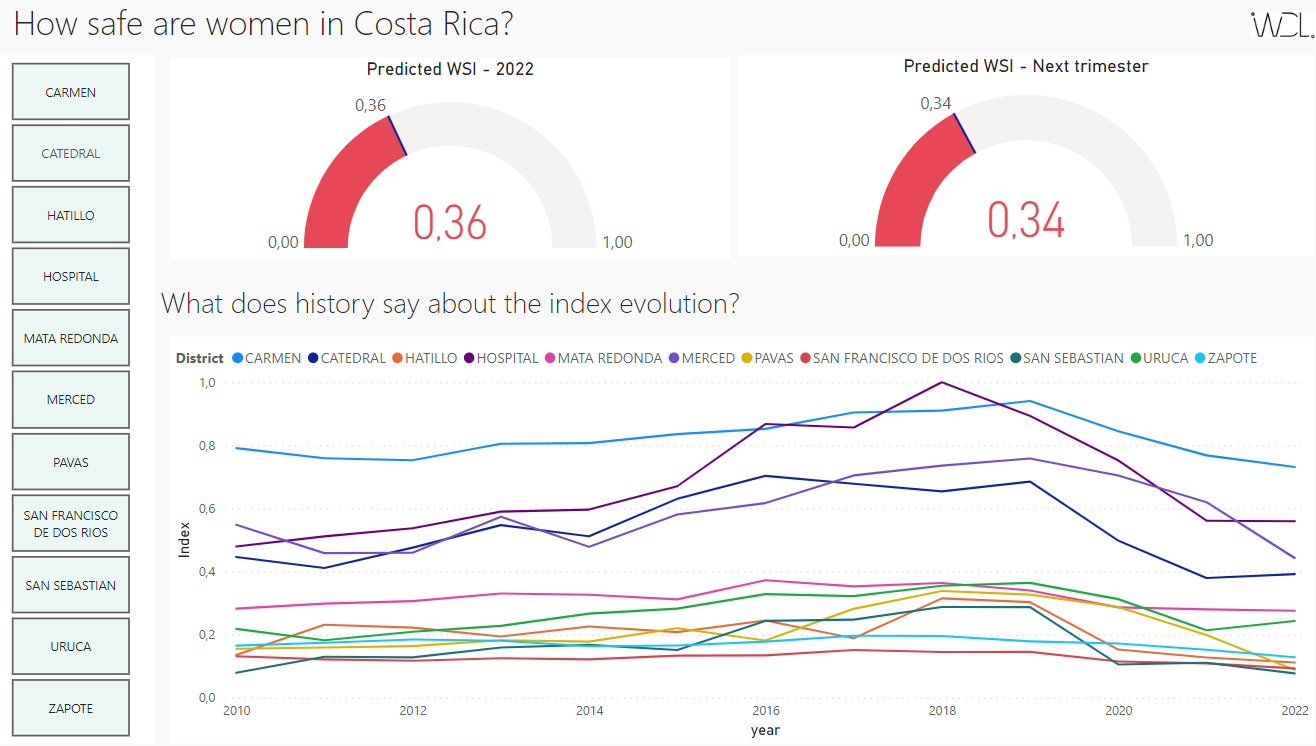

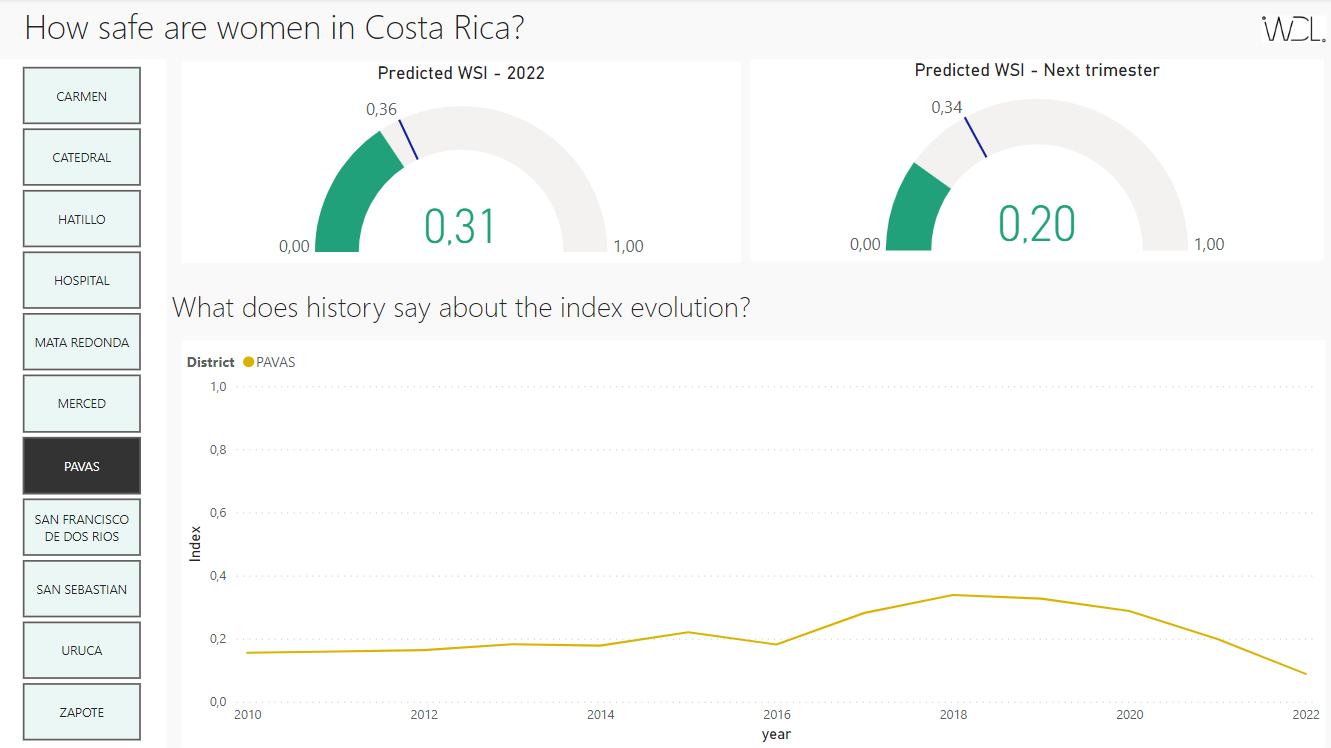